# Caruana Replication

In [1]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from pandas.plotting import table

## Define Algorithms

### Algorithm 1: Logistic Regression

In [2]:
def log_reg(X_train, X_test, y_train, y_test):
    # Logistic Regression binary classification
    C_list = [1e-4, 1e-3, 1e-2, 1e-1,1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8]
    scoring = ['accuracy', 'f1', 'roc_auc']
    param_grid = [{'classifier__C': C_list, 'classifier__penalty': ['l2']}, 
                  {'classifier__C': [None], 'classifier__penalty': ['none']}]
    pipe = Pipeline([('classifier', LogisticRegression())])
    clf = GridSearchCV(pipe, param_grid, return_train_score = True, 
                       n_jobs = -1, scoring = scoring, refit = False, cv=StratifiedKFold(n_splits=5))
    clf.fit(X_train, y_train)
    
    results = clf.cv_results_
    
    # Find best parameters and optimal for each performance metric
    best_C_acc = clf.cv_results_['params'][np.argmin(results['rank_test_accuracy'])]['classifier__C']
    best_penalty_acc = clf.cv_results_['params'][np.argmin(results['rank_test_accuracy'])]['classifier__penalty']
    
    best_C_f1 = clf.cv_results_['params'][np.argmin(results['rank_test_f1'])]['classifier__C']
    best_penalty_f1 = clf.cv_results_['params'][np.argmin(results['rank_test_f1'])]['classifier__penalty']

    best_C_roc = clf.cv_results_['params'][np.argmin(results['rank_test_roc_auc'])]['classifier__C']
    best_penalty_roc = clf.cv_results_['params'][np.argmin(results['rank_test_roc_auc'])]['classifier__penalty']

    print("Found Best Parameters!")
    
    # Train 3 models using the 5000 samples and each of the 3 best parameter settings (one model per metric)
    best_model_acc = LogisticRegression(C=best_C_acc, n_jobs = -1, penalty=best_penalty_acc)
    best_model_f1 = LogisticRegression(C=best_C_f1, n_jobs = -1, penalty = best_penalty_f1)
    best_model_roc = LogisticRegression(C=best_C_roc, n_jobs = -1, penalty = best_penalty_roc)
    best_model_acc.fit(X_train, y_train)
    best_model_f1.fit(X_train, y_train)
    best_model_roc.fit(X_train, y_train)
    
    # Find and store accuracy, FSC, and AUC of 3 models on train set
    y_train_pred1 = best_model_acc.predict(X_train)
    y_train_pred2 = best_model_f1.predict(X_train)
    y_train_pred3 = best_model_roc.predict(X_train)

    metrics_acc_train = accuracy_score(y_train, y_train_pred1)
    metrics_f1_train = f1_score(y_train, y_train_pred2)
    metrics_auc_train = roc_auc_score(y_train, y_train_pred3)

    # Find and store accuracy, FSC, and AUC of the 3 models from previous line on test set
    y_test_pred1 = best_model_acc.predict(X_test)
    y_test_pred2 = best_model_f1.predict(X_test)
    y_test_pred3 = best_model_roc.predict(X_test)
    
    metrics_acc_test = accuracy_score(y_test, y_test_pred1)
    metrics_f1_test = f1_score(y_test, y_test_pred2)
    metrics_auc_test = roc_auc_score(y_test, y_test_pred3)
    
    return metrics_acc_test, metrics_f1_test, metrics_auc_test, metrics_acc_train, metrics_f1_train, metrics_auc_train

### Algorithm 2: KNN

In [3]:
def knn(X_train, X_test, y_train, y_test):
    # KNN binary classification
    k_list = [i for i in range(1,106,4)]
    weights = ['uniform', 'distance']
    param_grid = [{'classifier__n_neighbors': k_list, 'classifier__weights': weights}]
    scoring = ['accuracy', 'f1', 'roc_auc']
    pipe = Pipeline([('classifier', KNeighborsClassifier())])
    clf = GridSearchCV(pipe, param_grid, return_train_score = True, 
                       n_jobs = -1, scoring = scoring, refit = False, cv=StratifiedKFold(n_splits=5))
    clf.fit(X_train, y_train)
    
    results = clf.cv_results_
    
    # Find best parameters for each performance metric
    best_k_acc = results['params'][np.argmin(results['rank_test_accuracy'])]['classifier__n_neighbors']
    best_weight_acc = results['params'][np.argmin(results['rank_test_accuracy'])]['classifier__weights']
    
    best_k_f1 = results['params'][np.argmin(results['rank_test_f1'])]['classifier__n_neighbors']
    best_weight_f1 = results['params'][np.argmin(results['rank_test_f1'])]['classifier__weights']
    
    best_k_roc = results['params'][np.argmin(results['rank_test_roc_auc'])]['classifier__n_neighbors']
    best_weight_roc = results['params'][np.argmin(results['rank_test_roc_auc'])]['classifier__weights']
    
    print("Found Best Parameters!") 
    
    # Train 3 models using the 5000 samples and each of the 3 best parameter settings (one model per metric)
    best_model_acc = KNeighborsClassifier(n_neighbors = best_k_acc, weights = best_weight_acc)
    best_model_f1 = KNeighborsClassifier(n_neighbors = best_k_f1, weights = best_weight_f1)
    best_model_roc = KNeighborsClassifier(n_neighbors = best_k_roc, weights = best_weight_roc)
    best_model_acc.fit(X_train, y_train)
    best_model_f1.fit(X_train, y_train)
    best_model_roc.fit(X_train, y_train)
    
    # Find and store accuracy, FSC, and AUC of 3 models on train set
    y_train_pred1 = best_model_acc.predict(X_train)
    y_train_pred2 = best_model_f1.predict(X_train)
    y_train_pred3 = best_model_roc.predict(X_train)

    metrics_acc_train = accuracy_score(y_train, y_train_pred1)
    metrics_f1_train = f1_score(y_train, y_train_pred2)
    metrics_auc_train = roc_auc_score(y_train, y_train_pred3)
    
    # Find and store accuracy, FSC, and AUC of the 3 models from previous line on test set
    y_test_pred1 = best_model_acc.predict(X_test)
    y_test_pred2 = best_model_f1.predict(X_test)
    y_test_pred3 = best_model_roc.predict(X_test)
    
    metrics_acc_test = accuracy_score(y_test, y_test_pred1)
    metrics_f1_test = f1_score(y_test, y_test_pred2)
    metrics_auc_test = roc_auc_score(y_test, y_test_pred3)
    
    return metrics_acc_test, metrics_f1_test, metrics_auc_test, metrics_acc_train, metrics_f1_train, metrics_auc_train

### Algorithm 3: Random Forest

In [4]:
def rand_for(X_train, X_test, y_train, y_test):
    # Random Forest binary classification
    feat_list = [1, 2, 4, 6, 8, 12, 16, 20]
    n_trees = [1024]
    scoring = ['accuracy', 'f1', 'roc_auc']
    param_grid = {'classifier__n_estimators': n_trees, 'classifier__max_features': feat_list}
    pipe = Pipeline([('classifier', RandomForestClassifier())])
    clf = GridSearchCV(pipe, param_grid, return_train_score = True, 
                       n_jobs = -1, scoring = scoring, refit = False, cv=StratifiedKFold(n_splits=5))
    clf.fit(X_train, y_train)
    
    results = clf.cv_results_
    
    # Find best parameters for each performance metric
    best_est_acc = results['params'][np.argmin(results['rank_test_accuracy'])]['classifier__n_estimators']
    best_feat_acc = results['params'][np.argmin(results['rank_test_accuracy'])]['classifier__max_features']
    
    best_est_f1 = results['params'][np.argmin(results['rank_test_f1'])]['classifier__n_estimators']
    best_feat_f1 = results['params'][np.argmin(results['rank_test_f1'])]['classifier__max_features']
    
    best_est_roc = results['params'][np.argmin(results['rank_test_roc_auc'])]['classifier__n_estimators']
    best_feat_roc = results['params'][np.argmin(results['rank_test_roc_auc'])]['classifier__max_features']
            
    print("Found Best Parameters!")
    
    # Train 3 models using the 5000 samples and each of the 3 best parameter settings (one model per metric)
    best_model_acc = RandomForestClassifier(n_estimators=best_est_acc, n_jobs = -1, max_features = best_feat_acc)
    best_model_f1 = RandomForestClassifier(n_estimators=best_est_f1, n_jobs = -1, max_features = best_feat_f1)
    best_model_auc = RandomForestClassifier(n_estimators=best_est_roc, n_jobs = -1, max_features = best_feat_roc)
    best_model_acc.fit(X_train, y_train)
    best_model_f1.fit(X_train, y_train)
    best_model_auc.fit(X_train, y_train)
    
    # Find and store accuracy, FSC, and AUC of 3 models on train set
    y_train_pred1 = best_model_acc.predict(X_train)
    y_train_pred2 = best_model_f1.predict(X_train)
    y_train_pred3 = best_model_auc.predict(X_train)

    metrics_acc_train = accuracy_score(y_train, y_train_pred1)
    metrics_f1_train = f1_score(y_train, y_train_pred2)
    metrics_auc_train = roc_auc_score(y_train, y_train_pred3)
    
    # Find and store accuracy, FSC, and AUC of the 3 models from previous line on test set
    y_test_pred1 = best_model_acc.predict(X_test)
    y_test_pred2 = best_model_f1.predict(X_test)
    y_test_pred3 = best_model_auc.predict(X_test)
    
    metrics_acc_test = accuracy_score(y_test, y_test_pred1)
    metrics_f1_test = f1_score(y_test, y_test_pred2)
    metrics_auc_test = roc_auc_score(y_test, y_test_pred3)
    
    return metrics_acc_test, metrics_f1_test, metrics_auc_test, metrics_acc_train, metrics_f1_train, metrics_auc_train

## Adult Classification Problem

### Import Data

In [2]:
cols1 = ['age', 'workclass', 'fnlwgt','education', 'education-num', 'marital-status', 
        'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
        'hours-per-week', 'native-country', 'class']
features = ['age', 'workclass', 'fnlwgt','education', 'education-num', 'marital-status', 
        'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
        'hours-per-week', 'native-country']
data1_1 = pd.read_csv('./ADULT/adult.data', header = None, names = cols1)
data1_2 = pd.read_csv('./ADULT/adult.test', header = None, names = cols1)
frames = [data1_1, data1_2]
data1 = pd.concat(frames)
data1 = data1.reset_index()

In [3]:
data1.shape

(48843, 16)

### Clean and Preprocess Data

In [4]:
# Types in each column
print(data1.dtypes)

# Drop any nulls, shown as question marks
for i in range(len(data1)):
    for col in cols1:
        if data1[col][i] == ' ?':
            data1.drop(i, inplace = True)
            break

index               int64
age                object
workclass          object
fnlwgt            float64
education          object
education-num     float64
marital-status     object
occupation         object
relationship       object
race               object
sex                object
capital-gain      float64
capital-loss      float64
hours-per-week    float64
native-country     object
class              object
dtype: object


In [5]:
data1.shape

(45223, 16)

In [6]:
# Preprocess last column
def transform_income(income):
    if income == ' <=50K':
        return 0
    else:
        return 1

In [7]:
data1['class'] = data1['class'].apply(transform_income)

In [8]:
data1.head(10)

,index,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,0
1,1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,0
2,2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,0
3,3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,0
4,4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,0
5,5,37,Private,284582.0,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,0
6,6,49,Private,160187.0,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,0
7,7,52,Self-emp-not-inc,209642.0,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,1
8,8,31,Private,45781.0,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,1
9,9,42,Private,159449.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,1


In [9]:
data1 = data1.dropna()

In [10]:
data1.shape

(45222, 16)

In [20]:
data1.loc[data1['class'] == 1, 'class'].sum()

22568

In [11]:
X1 = data1[features]
y1 = data1['class']

In [12]:
X1.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


In [13]:
features

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country']

In [14]:
# One-hot encode categorical data
X1 = pd.get_dummies(X1, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race',
 'sex','native-country'])

In [15]:
X1.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,77516.0,13.0,2174.0,0.0,40.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311.0,13.0,0.0,0.0,13.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646.0,9.0,0.0,0.0,40.0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721.0,7.0,0.0,0.0,40.0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409.0,13.0,0.0,0.0,40.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Standardize continuous data
scaler = StandardScaler()
X1[['age','fnlwgt', 'education-num','capital-gain',
    'capital-loss','hours-per-week']] = scaler.fit_transform(X1[['age','fnlwgt', 'education-num',
                                                                 'capital-gain','capital-loss','hours-per-week']])

In [17]:
X1.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0.034201,-1.062295,1.128753,0.142888,-0.21878,-0.078120,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.866417,-1.007438,1.128753,-0.146733,-0.21878,-2.326738,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,-0.041455,0.245284,-0.438122,-0.146733,-0.21878,-0.078120,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,1.093385,0.425853,-1.221559,-0.146733,-0.21878,-0.078120,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,-0.798015,1.407393,1.128753,-0.146733,-0.21878,-0.078120,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# Types in each column
print(X1.dtypes)
print(y1.dtypes)

age                                float64
fnlwgt                             float64
education-num                      float64
capital-gain                       float64
capital-loss                       float64
                                    ...   
native-country_ Thailand             uint8
native-country_ Trinadad&Tobago      uint8
native-country_ United-States        uint8
native-country_ Vietnam              uint8
native-country_ Yugoslavia           uint8
Length: 104, dtype: object
int64


In [19]:
X1.shape

(45222, 104)

In [20]:
y1.shape

(45222,)

### Classification: Dataset 1

In [25]:
%%time
# Tables to store data
LRD1_test = np.zeros((5, 3))
LRD1_train = np.zeros((5, 3))
KNND1_test = np.zeros((5, 3))
KNND1_train = np.zeros((5, 3))
RDF1_test = np.zeros((5, 3))
RDF1_train = np.zeros((5, 3))

# Loop for 5 trials
for trial in range(5):
    # Random sampling of data
    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, train_size = 5000)
    
    # Run models
    acc_log_test, f1_log_test, auc_log_test, acc_log_train, f1_log_train, auc_log_train = log_reg(X1_train, 
                                                                                                  X1_test, y1_train, 
                                                                                                  y1_test)
    acc_knn_test, f1_knn_test, auc_knn_test, acc_knn_train, f1_knn_train, auc_knn_train = knn(X1_train, 
                                                                                              X1_test, y1_train, 
                                                                                              y1_test)
    acc_rf_test, f1_rf_test, auc_rf_test, acc_rf_train, f1_rf_train, auc_rf_train = rand_for(X1_train, X1_test, 
                                                                                             y1_train, y1_test)
    
    # Store results
    LRD1_test[trial][0] = acc_log_test
    LRD1_train[trial][0] = acc_log_train
    LRD1_test[trial][1] = f1_log_test
    LRD1_train[trial][1] = f1_log_train
    LRD1_test[trial][2] = auc_log_test
    LRD1_train[trial][2] = auc_log_train
    
    KNND1_test[trial][0] = acc_knn_test
    KNND1_train[trial][0] = acc_knn_train
    KNND1_test[trial][1] = f1_knn_test
    KNND1_train[trial][1] = f1_knn_train
    KNND1_test[trial][2] = auc_knn_test
    KNND1_train[trial][2] = auc_knn_train
    
    RDF1_test[trial][0] = acc_rf_test
    RDF1_train[trial][0] = acc_rf_train
    RDF1_test[trial][1] = f1_rf_test
    RDF1_train[trial][1] = f1_rf_train
    RDF1_test[trial][2] = auc_rf_test
    RDF1_train[trial][2] = auc_rf_train

# Make dataframes from tables
LRD1_test = pd.DataFrame(LRD1_test, columns=['accuracy', 'f1', 'roc_auc'])
LRD1_train = pd.DataFrame(LRD1_train, columns=['accuracy', 'f1', 'roc_auc'])
KNND1_test = pd.DataFrame(KNND1_test, columns=['accuracy', 'f1', 'roc_auc'])
KNND1_train = pd.DataFrame(KNND1_train, columns=['accuracy', 'f1', 'roc_auc'])
RDF1_test = pd.DataFrame(RDF1_test, columns=['accuracy', 'f1', 'roc_auc'])
RDF1_train = pd.DataFrame(RDF1_train, columns=['accuracy', 'f1', 'roc_auc'])

AD1_test = [[LRD1_test], [KNND1_test], [RDF1_test]]
AD1_test = pd.DataFrame(AD1_test, columns = ['ADULT'], index = ['LR', 'KNN', 'RAND_FOR'])
AD1_train = [[LRD1_train], [KNND1_train], [RDF1_train]]
AD1_train = pd.DataFrame(AD1_train, columns = ['ADULT'], index = ['LR', 'KNN', 'RAND_FOR'])

/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.65   0.6484 0.6422 0.6452 0.639  0.6374 0.638  0.6378 0.6386 0.6366
 0.6376 0.6386 0.6386    nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.6494  0.6515  0.6542  0.6572  0.6606  0.6607  0.66025 0.6605  0.6603
 0.66105 0.66075 0.661   0.6608      nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.62328535 0.63652074 0.63401525 0.63243217 0.62485771 0.62356577
 0.62538004 0.62433763 0.62564715 0.62323204 0.62431553 0.6258092
 0.62520541        nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.62360224 0.64016

Found Best Parameters!
Found Best Parameters!
Found Best Parameters!


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.6456 0.6482 0.6498 0.6472 0.6436 0.642  0.6412 0.642  0.6424 0.6422
 0.6418 0.6402 0.6418    nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.64805 0.6503  0.6573  0.6573  0.6591  0.65865 0.6586  0.6593  0.6595
 0.65915 0.65985 0.65995 0.6594      nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.63779723 0.64321286 0.64472268 0.63859743 0.63389267 0.63301029
 0.63202193 0.63286873 0.63296381 0.63313683 0.63272803 0.63140105
 0.63287662        nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.64072761 0.6447

Found Best Parameters!
Found Best Parameters!
Found Best Parameters!


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.6352 0.637  0.6386 0.6368 0.6336 0.6322 0.6312 0.6308 0.6316 0.6326
 0.6334 0.6324 0.6326    nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.6368  0.6375  0.6418  0.6449  0.6468  0.648   0.6481  0.64885 0.64875
 0.64805 0.6486  0.6483  0.6481      nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.6337721  0.63237589 0.63201942 0.62591875 0.61995804 0.61907425
 0.61824784 0.61766119 0.61801454 0.61949192 0.62046983 0.6189975
 0.61945916        nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.63549411 0.6329

Found Best Parameters!
Found Best Parameters!
Found Best Parameters!


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.637  0.6418 0.6496 0.6436 0.6392 0.6364 0.637  0.6356 0.637  0.6368
 0.6372 0.6378 0.6382    nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.6387  0.64265 0.65345 0.6588  0.65985 0.65995 0.65975 0.65955 0.66035
 0.6604  0.6603  0.66    0.66035     nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.63630501 0.63841064 0.6453747  0.63295873 0.62731924 0.62538176
 0.6254515  0.62439178 0.62560354 0.62515832 0.62509811 0.62625983
 0.62649964        nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.63826771 0.639

Found Best Parameters!


/opt/conda/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Found Best Parameters!
Found Best Parameters!


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.6202 0.6446 0.6438 0.6424 0.639  0.6368 0.6374 0.6356 0.6356 0.6368
 0.6358 0.636  0.635     nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.6228  0.64835 0.6518  0.6549  0.65795 0.65805 0.658   0.65795 0.6573
 0.65775 0.6577  0.65795 0.6579      nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.65775276 0.65139361 0.64623273 0.6384179  0.63360862 0.63131495
 0.63139339 0.63008445 0.63037762 0.63130667 0.63095649 0.63063513
 0.62953299        nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.65962848 0.6542

Found Best Parameters!
Found Best Parameters!
Found Best Parameters!
CPU times: user 8min 30s, sys: 10min 10s, total: 18min 41s
Wall time: 36min 32s


In [26]:
LRD1_test

,accuracy,f1,roc_auc
0,0.648004,0.637431,0.650773
1,0.648352,0.641888,0.648317
2,0.648526,0.643226,0.648503
3,0.650266,0.642361,0.650219
4,0.642559,0.655206,0.646665


In [27]:
LRD1_train

,accuracy,f1,roc_auc
0,0.6490,0.639835,0.652101
1,0.6556,0.651558,0.655595
2,0.6384,0.634058,0.638432
3,0.6532,0.648418,0.653217
4,0.6500,0.657489,0.651100


In [28]:
KNND1_test

,accuracy,f1,roc_auc
0,0.640669,0.618143,0.641844
1,0.644846,0.622340,0.644724
2,0.643504,0.623637,0.643562
3,0.643976,0.613684,0.643784
4,0.648700,0.633883,0.648024


In [29]:
KNND1_train

,accuracy,f1,roc_auc
0,0.6674,1.000000,1.000000
1,0.6532,0.631221,0.653176
2,0.6534,0.621645,0.999800
3,1.0000,0.630736,1.000000
4,0.6434,0.634156,1.000000


In [30]:
RDF1_test

,accuracy,f1,roc_auc
0,0.630178,0.597705,0.629814
1,0.634777,0.607723,0.634830
2,0.622271,0.595176,0.623053
3,0.632415,0.604092,0.635773
4,0.632639,0.609638,0.632216


In [31]:
RDF1_train

,accuracy,f1,roc_auc
0,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000
2,0.9998,0.9998,0.9998
3,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000


## Cover Type Classification Problem

### Import Data

In [21]:
cols2 = ['elevation', 'aspect', 'slope', 'horizontal_distance_to_hydrology', 'vertical_distance_to_hydrology',
       'horizontal_distance_to_roadways', 'hillshade_9am', 'hillshade_noon', 'hillshade_3pm', 
       'horizontal_distance_to_fire_points', 'wilderness_area1', 'wilderness_area2','wilderness_area3',
         'wilderness_area4', 'soil_type1','soil_type2','soil_type3','soil_type4','soil_type5','soil_type6',
         'soil_type7','soil_type8','soil_type9','soil_type10','soil_type11','soil_type12','soil_type13',
         'soil_type14','soil_type15','soil_type16','soil_type17','soil_type18', 'soil_type19', 'soil_type20', 
         'soil_type21', 'soil_type22', 'soil_type23', 'soil_type24', 'soil_type25', 'soil_type26','soil_type27', 
         'soil_type28', 'soil_type29', 'soil_type30', 'soil_type31', 'soil_type32', 'soil_type33', 'soil_type34', 
         'soil_type35', 'soil_type36', 'soil_type37', 'soil_type38', 'soil_type39', 'soil_type40', 'cover_type']
data2 = pd.read_csv('./COVTYPE/covtype.data', header = None, names = cols2)

In [22]:
data2.head()

,elevation,aspect,slope,horizontal_distance_to_hydrology,vertical_distance_to_hydrology,horizontal_distance_to_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,horizontal_distance_to_fire_points,...,soil_type32,soil_type33,soil_type34,soil_type35,soil_type36,soil_type37,soil_type38,soil_type39,soil_type40,cover_type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [23]:
data2.shape

(581012, 55)

### Clean and Preprocess Data

In [24]:
# Types in each column
print(data2.dtypes)

elevation                             int64
aspect                                int64
slope                                 int64
horizontal_distance_to_hydrology      int64
vertical_distance_to_hydrology        int64
horizontal_distance_to_roadways       int64
hillshade_9am                         int64
hillshade_noon                        int64
hillshade_3pm                         int64
horizontal_distance_to_fire_points    int64
wilderness_area1                      int64
wilderness_area2                      int64
wilderness_area3                      int64
wilderness_area4                      int64
soil_type1                            int64
soil_type2                            int64
soil_type3                            int64
soil_type4                            int64
soil_type5                            int64
soil_type6                            int64
soil_type7                            int64
soil_type8                            int64
soil_type9                      

In [25]:
# Check if there are any null variables
data2.isnull().values.any()

False

In [26]:
# Method in Caruana Paper: Largest class(7) is positive and everything else is negative
def transform_type(covtype):
    if covtype == 7:
        return 1
    else:
        return 0

In [27]:
data2['cover_type'] = data2['cover_type'].apply(transform_type)

In [28]:
data2.head()

,elevation,aspect,slope,horizontal_distance_to_hydrology,vertical_distance_to_hydrology,horizontal_distance_to_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,horizontal_distance_to_fire_points,...,soil_type32,soil_type33,soil_type34,soil_type35,soil_type36,soil_type37,soil_type38,soil_type39,soil_type40,cover_type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,0
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,0
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,0
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,0
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# Only picked a subset of dataset to match size in Caruana paper
X2 = data2.iloc[:30000, :-1]
y2 = data2.iloc[:30000, -1]

In [32]:
X2.shape

(30000, 54)

In [39]:
y2.sum()

2160

In [41]:
X2.columns

Index(['elevation', 'aspect', 'slope', 'horizontal_distance_to_hydrology',
       'vertical_distance_to_hydrology', 'horizontal_distance_to_roadways',
       'hillshade_9am', 'hillshade_noon', 'hillshade_3pm',
       'horizontal_distance_to_fire_points', 'wilderness_area1',
       'wilderness_area2', 'wilderness_area3', 'wilderness_area4',
       'soil_type1', 'soil_type2', 'soil_type3', 'soil_type4', 'soil_type5',
       'soil_type6', 'soil_type7', 'soil_type8', 'soil_type9', 'soil_type10',
       'soil_type11', 'soil_type12', 'soil_type13', 'soil_type14',
       'soil_type15', 'soil_type16', 'soil_type17', 'soil_type18',
       'soil_type19', 'soil_type20', 'soil_type21', 'soil_type22',
       'soil_type23', 'soil_type24', 'soil_type25', 'soil_type26',
       'soil_type27', 'soil_type28', 'soil_type29', 'soil_type30',
       'soil_type31', 'soil_type32', 'soil_type33', 'soil_type34',
       'soil_type35', 'soil_type36', 'soil_type37', 'soil_type38',
       'soil_type39', 'soil_type40

In [42]:
X2[['elevation', 'aspect', 'slope', 'horizontal_distance_to_hydrology',
       'vertical_distance_to_hydrology', 'horizontal_distance_to_roadways',
       'hillshade_9am', 'hillshade_noon', 'hillshade_3pm',
       'horizontal_distance_to_fire_points', 'wilderness_area1',
       'wilderness_area2', 'wilderness_area3', 'wilderness_area4']]

,elevation,aspect,slope,horizontal_distance_to_hydrology,vertical_distance_to_hydrology,horizontal_distance_to_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,horizontal_distance_to_fire_points,wilderness_area1,wilderness_area2,wilderness_area3,wilderness_area4
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,3109,41,15,0,0,5202,221,205,116,1317,1,0,0,0
29996,3109,28,11,0,0,5217,216,216,135,1333,1,0,0,0
29997,3103,76,9,30,-5,5232,231,224,126,1348,1,0,0,0
29998,3100,158,8,42,-5,5248,229,242,145,1365,1,0,0,0


In [43]:
# Standardize continuous data
scaler = StandardScaler()
X2[['elevation', 'aspect', 'slope', 'horizontal_distance_to_hydrology',
       'vertical_distance_to_hydrology', 'horizontal_distance_to_roadways',
       'hillshade_9am', 'hillshade_noon', 'hillshade_3pm',
       'horizontal_distance_to_fire_points']] = scaler.fit_transform(X2[['elevation', 'aspect', 'slope', 
                                                                         'horizontal_distance_to_hydrology',
                                                                         'vertical_distance_to_hydrology', 
                                                                         'horizontal_distance_to_roadways',
                                                                         'hillshade_9am', 'hillshade_noon', 
                                                                         'hillshade_3pm',
                                                                         'horizontal_distance_to_fire_points']])

In [44]:
X2.head()

,elevation,aspect,slope,horizontal_distance_to_hydrology,vertical_distance_to_hydrology,horizontal_distance_to_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,horizontal_distance_to_fire_points,...,soil_type31,soil_type32,soil_type33,soil_type34,soil_type35,soil_type36,soil_type37,soil_type38,soil_type39,soil_type40
0,-0.571152,-0.865259,-1.376567,0.277392,-0.766361,-1.125637,0.202438,0.521856,0.300395,1.422766,...,0,0,0,0,0,0,0,0,0,0
1,-0.589768,-0.819037,-1.499635,0.027023,-0.885385,-1.188955,0.165453,0.674875,0.379244,1.397732,...,0,0,0,0,0,0,0,0,0,0
2,0.074225,-0.051749,-0.638160,0.331820,0.523066,0.283179,0.683242,0.827893,-0.041284,1.349518,...,0,0,0,0,0,0,0,0,0,0
3,0.015273,0.096162,0.469450,0.190307,1.574445,0.235691,0.831182,0.827893,-0.382962,1.391242,...,0,0,0,0,0,0,0,0,0,0
4,-0.574255,-0.920726,-1.499635,-0.294102,-0.786199,-1.188427,0.165453,0.623868,0.352961,1.373162,...,0,0,0,0,0,0,0,0,0,0


In [45]:
# Types in each column
print(X2.dtypes)
print(y2.dtypes)

elevation                             float64
aspect                                float64
slope                                 float64
horizontal_distance_to_hydrology      float64
vertical_distance_to_hydrology        float64
horizontal_distance_to_roadways       float64
hillshade_9am                         float64
hillshade_noon                        float64
hillshade_3pm                         float64
horizontal_distance_to_fire_points    float64
wilderness_area1                        int64
wilderness_area2                        int64
wilderness_area3                        int64
wilderness_area4                        int64
soil_type1                              int64
soil_type2                              int64
soil_type3                              int64
soil_type4                              int64
soil_type5                              int64
soil_type6                              int64
soil_type7                              int64
soil_type8                        

### Classification: Dataset 2

In [46]:
%%time

# Tables to store data
LRD2_test = np.zeros((5, 3))
LRD2_train = np.zeros((5, 3))
KNND2_test = np.zeros((5, 3))
KNND2_train = np.zeros((5, 3))
RDF2_test = np.zeros((5, 3))
RDF2_train = np.zeros((5, 3))

# Loop to run trials
for trial in range(5):
    # Random sampling of data
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, train_size = 5000)
    
    # Run models
    acc_log_test, f1_log_test, auc_log_test, acc_log_train, f1_log_train, auc_log_train = log_reg(X2_train, 
                                                                                                  X2_test, y2_train, 
                                                                                                  y2_test)
    acc_knn_test, f1_knn_test, auc_knn_test, acc_knn_train, f1_knn_train, auc_knn_train = knn(X2_train, 
                                                                                              X2_test, y2_train, 
                                                                                              y2_test)
    acc_rf_test, f1_rf_test, auc_rf_test, acc_rf_train, f1_rf_train, auc_rf_train = rand_for(X2_train, X2_test, 
                                                                                             y2_train, y2_test)
    
    # Collect results
    LRD2_test[trial][0] = acc_log_test
    LRD2_train[trial][0] = acc_log_train
    LRD2_test[trial][1] = f1_log_test
    LRD2_train[trial][1] = f1_log_train
    LRD2_test[trial][2] = auc_log_test
    LRD2_train[trial][2] = auc_log_train
    
    KNND2_test[trial][0] = acc_knn_test
    KNND2_train[trial][0] = acc_knn_train
    KNND2_test[trial][1] = f1_knn_test
    KNND2_train[trial][1] = f1_knn_train
    KNND2_test[trial][2] = auc_knn_test
    KNND2_train[trial][2] = auc_knn_train
    
    RDF2_test[trial][0] = acc_rf_test
    RDF2_train[trial][0] = acc_rf_train
    RDF2_test[trial][1] = f1_rf_test
    RDF2_train[trial][1] = f1_rf_train
    RDF2_test[trial][2] = auc_rf_test
    RDF2_train[trial][2] = auc_rf_train

# Make tables into dataframes
LRD2_test = pd.DataFrame(LRD2_test, columns=['accuracy', 'f1', 'roc_auc'])
LRD2_train = pd.DataFrame(LRD2_train, columns=['accuracy', 'f1', 'roc_auc'])
KNND2_test = pd.DataFrame(KNND2_test, columns=['accuracy', 'f1', 'roc_auc'])
KNND2_train = pd.DataFrame(KNND2_train, columns=['accuracy', 'f1', 'roc_auc'])
RDF2_test = pd.DataFrame(RDF2_test, columns=['accuracy', 'f1', 'roc_auc'])
RDF2_train = pd.DataFrame(RDF2_train, columns=['accuracy', 'f1', 'roc_auc'])

AD2_test = [[LRD2_test], [KNND2_test], [RDF2_test]]
AD2_test = pd.DataFrame(AD2_test, columns = ['COVTYPE'], index = ['LR', 'KNN', 'RAND_FOR'])
AD2_train = [[LRD2_train], [KNND2_train], [RDF2_train]]
AD2_train = pd.DataFrame(AD2_train, columns = ['COVTYPE'], index = ['LR', 'KNN', 'RAND_FOR'])

/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.9318 0.9318 0.9602 0.9828 0.983  0.9816 0.981  0.981  0.981  0.981
 0.9812 0.981  0.981     nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.9318  0.9318  0.9614  0.9842  0.98505 0.9852  0.98545 0.98545 0.9854
 0.98545 0.98545 0.98545 0.9854      nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.         0.         0.59729583 0.86916231 0.87344723 0.86364614
 0.85881701 0.85881701 0.85881701 0.85881701 0.86063387 0.85881701
 0.85881701        nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.         0.     

Found Best Parameters!
Found Best Parameters!
Found Best Parameters!


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.9314 0.9314 0.9564 0.9798 0.9804 0.9796 0.9794 0.9794 0.9794 0.9794
 0.9794 0.9792 0.9794    nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.9314  0.9314  0.9581  0.98075 0.9814  0.98255 0.98285 0.98285 0.9828
 0.98265 0.9828  0.98275 0.98285     nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.         0.         0.5478341  0.84650378 0.85377363 0.84885099
 0.84753246 0.84753246 0.84753246 0.84753246 0.84753246 0.84623376
 0.84753246        nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.         0.    

Found Best Parameters!
Found Best Parameters!
Found Best Parameters!


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.9248 0.9254 0.9586 0.9826 0.9834 0.9834 0.9838 0.9838 0.9836 0.9836
 0.9836 0.9836 0.9834    nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.9248  0.92545 0.9593  0.9832  0.9867  0.98715 0.98715 0.98725 0.98725
 0.9873  0.9873  0.98735 0.9872      nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.         0.01551957 0.63097902 0.87850009 0.88631609 0.88670238
 0.88925077 0.88895931 0.88747191 0.88747191 0.88747191 0.88747191
 0.8863109         nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.         0.017

Found Best Parameters!
Found Best Parameters!
Found Best Parameters!


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.9284 0.9284 0.9588 0.982  0.9832 0.9828 0.9832 0.9832 0.9832 0.9832
 0.9832 0.9832 0.9832    nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.9284  0.9284  0.9596  0.9837  0.98465 0.9846  0.98475 0.98485 0.98495
 0.985   0.985   0.98495 0.9849      nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.         0.         0.61470702 0.87167751 0.88169814 0.87880127
 0.88170453 0.88170453 0.88170453 0.88170453 0.88170453 0.88170453
 0.88170453        nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.         0.   

Found Best Parameters!
Found Best Parameters!
Found Best Parameters!


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.9298 0.9298 0.9546 0.9804 0.98   0.9808 0.981  0.9802 0.9804 0.9802
 0.9802 0.9802 0.9802    nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.9298  0.9298  0.95595 0.98145 0.9822  0.98305 0.98305 0.98315 0.9832
 0.983   0.983   0.98315 0.98305     nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.         0.         0.53859404 0.8562968  0.85599925 0.86271081
 0.86439861 0.85909179 0.86070707 0.85909179 0.85909179 0.85909179
 0.85909179        nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.         0.    

Found Best Parameters!
Found Best Parameters!
Found Best Parameters!
CPU times: user 4min 18s, sys: 8min 6s, total: 12min 25s
Wall time: 27min 40s


In [47]:
LRD2_test

,accuracy,f1,roc_auc
0,0.98224,0.874647,0.922030
1,0.98292,0.880559,0.929163
2,0.98256,0.878484,0.936642
3,0.98268,0.874248,0.917408
4,0.98164,0.869713,0.919026


In [48]:
LRD2_train

,accuracy,f1,roc_auc
0,0.9840,0.880952,0.930261
1,0.9802,0.853333,0.915101
2,0.9870,0.913218,0.946332
3,0.9840,0.892351,0.934885
4,0.9824,0.873926,0.928746


In [49]:
KNND2_test

,accuracy,f1,roc_auc
0,0.98116,0.871697,0.892429
1,0.98004,0.863996,0.887508
2,0.97792,0.859572,0.890140
3,0.98020,0.864048,0.904100
4,0.98212,0.877702,0.902633


In [50]:
KNND2_train

,accuracy,f1,roc_auc
0,1.0,1.0,1.0
1,1.0,1.0,1.0
2,1.0,1.0,1.0
3,1.0,1.0,1.0
4,1.0,1.0,1.0


In [51]:
RDF2_test

,accuracy,f1,roc_auc
0,0.98508,0.902247,0.952024
1,0.98640,0.912027,0.954420
2,0.98652,0.908486,0.954990
3,0.98780,0.914793,0.939975
4,0.98552,0.906932,0.953425


In [52]:
RDF2_train

,accuracy,f1,roc_auc
0,1.0,1.0,1.0
1,1.0,1.0,1.0
2,1.0,1.0,1.0
3,1.0,1.0,1.0
4,1.0,1.0,1.0


## Letter Classification Problem

### Import Data

In [40]:
cols3 = ['lettr', 'x-box', 'y-box', 'width', 'high', 'onpix', 'x-bar', 
         'y-bar', 'x2bar', 'y2bar', 'xybar', 'x2ybr', 'xy2br', 'x-ege', 'xegvy',
        'y-ege', 'yegvx']
data3 = pd.read_csv('./LETTER/letter-recognition.data', header = None, names = cols3)

In [41]:
data3.head()

,lettr,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


### Clean and Preprocess Data

In [42]:
# Types in each column
print(data3.dtypes)

# Check if there are any null variables
data3.isnull().values.any()

lettr    object
x-box     int64
y-box     int64
width     int64
high      int64
onpix     int64
x-bar     int64
y-bar     int64
x2bar     int64
y2bar     int64
xybar     int64
x2ybr     int64
xy2br     int64
x-ege     int64
xegvy     int64
y-ege     int64
yegvx     int64
dtype: object


False

In [43]:
# Method in Caruana Paper: A-M is positive and everything else is negative
def transform_letter(letter):
    positive = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M']
    if letter in positive:
        return 1
    else:
        return 0

In [44]:
data3['lettr'] = data3['lettr'].apply(transform_letter)

In [45]:
data3.head()

,lettr,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,0,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,1,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,1,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,0,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,1,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [48]:
data3.shape

(20000, 17)

In [47]:
data3.loc[data3['lettr'] == 1, 'lettr'].sum()

9201

In [59]:
X3 = data3.iloc[:, 1:]
y3 = data3.iloc[:, 0]

In [60]:
X3.head()

,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [61]:
X3.shape

(20000, 16)

In [62]:
X3.columns

Index(['x-box', 'y-box', 'width', 'high', 'onpix', 'x-bar', 'y-bar', 'x2bar',
       'y2bar', 'xybar', 'x2ybr', 'xy2br', 'x-ege', 'xegvy', 'y-ege', 'yegvx'],
      dtype='object')

In [63]:
y3.head()

0    0
1    1
2    1
3    0
4    1
Name: lettr, dtype: int64

In [64]:
y3.shape

(20000,)

In [65]:
# Standardize continuous data
scaler = StandardScaler()
X3[['x-box', 'y-box', 'width', 'high', 'onpix', 
    'x-bar', 'y-bar', 'x2bar','y2bar', 'xybar', 
    'x2ybr', 'xy2br', 'x-ege', 'xegvy', 'y-ege', 'yegvx']] = scaler.fit_transform(X3[['x-box', 'y-box', 'width', 
                                                                                      'high', 'onpix', 'x-bar', 
                                                                                      'y-bar', 'x2bar', 'y2bar', 
                                                                                      'xybar', 'x2ybr', 'xy2br', 
                                                                                      'x-ege', 'xegvy', 'y-ege', 
                                                                                      'yegvx']])

In [66]:
X3.head()

,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,-1.057698,0.291877,-1.053277,-0.164704,-1.144013,0.544130,2.365097,-1.714360,0.344994,-0.917071,1.347774,0.034125,-1.305948,-0.219082,-1.438153,0.122911
1,0.510385,1.502358,-1.053277,0.719730,-0.687476,1.531305,-1.075326,0.137561,-0.495072,1.895968,-1.312807,0.514764,-0.448492,-0.219082,0.120081,1.359441
2,-0.012309,1.199738,0.435910,1.161947,1.138672,1.531305,-0.645273,-0.973591,0.344994,0.690380,-1.312807,-0.446513,-0.019764,-0.865626,-0.269477,0.741176
3,1.555774,1.199738,0.435910,0.277513,-0.230939,-0.936631,0.644886,-0.232823,0.344994,-1.720796,-0.932724,0.995402,1.266419,1.074008,-0.659036,0.122911
4,-1.057698,-1.826464,-1.053277,-1.933571,-1.144013,0.544130,-0.645273,0.507945,0.344994,-0.917071,-0.552641,0.514764,-0.877220,-0.865626,0.509640,1.359441


### Classification: Dataset 3

In [67]:
%%time
# Make tables to store data
LRD3_test = np.zeros((5, 3))
LRD3_train = np.zeros((5, 3))
KNND3_test = np.zeros((5, 3))
KNND3_train = np.zeros((5, 3))
RDF3_test = np.zeros((5, 3))
RDF3_train = np.zeros((5, 3))

# Loop to run trials
for trial in range(5):
    # Random sampling of data
    X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, train_size = 5000)
    
    # Run models
    acc_log_test, f1_log_test, auc_log_test, acc_log_train, f1_log_train, auc_log_train = log_reg(X3_train, 
                                                                                                  X3_test, y3_train, 
                                                                                                  y3_test)
    acc_knn_test, f1_knn_test, auc_knn_test, acc_knn_train, f1_knn_train, auc_knn_train = knn(X3_train, 
                                                                                              X3_test, y3_train, 
                                                                                              y3_test)
    acc_rf_test, f1_rf_test, auc_rf_test, acc_rf_train, f1_rf_train, auc_rf_train = rand_for(X3_train, X3_test, 
                                                                                             y3_train, y3_test)
    
    # Store results
    LRD3_test[trial][0] = acc_log_test
    LRD3_train[trial][0] = acc_log_train
    LRD3_test[trial][1] = f1_log_test
    LRD3_train[trial][1] = f1_log_train
    LRD3_test[trial][2] = auc_log_test
    LRD3_train[trial][2] = auc_log_train
    
    KNND3_test[trial][0] = acc_knn_test
    KNND3_train[trial][0] = acc_knn_train
    KNND3_test[trial][1] = f1_knn_test
    KNND3_train[trial][1] = f1_knn_train
    KNND3_test[trial][2] = auc_knn_test
    KNND3_train[trial][2] = auc_knn_train
    
    RDF3_test[trial][0] = acc_rf_test
    RDF3_train[trial][0] = acc_rf_train
    RDF3_test[trial][1] = f1_rf_test
    RDF3_train[trial][1] = f1_rf_train
    RDF3_test[trial][2] = auc_rf_test
    RDF3_train[trial][2] = auc_rf_train

# Make dataframes from tables
LRD3_test = pd.DataFrame(LRD3_test, columns=['accuracy', 'f1', 'roc_auc'])
LRD3_train = pd.DataFrame(LRD3_train, columns=['accuracy', 'f1', 'roc_auc'])
KNND3_test = pd.DataFrame(KNND3_test, columns=['accuracy', 'f1', 'roc_auc'])
KNND3_train = pd.DataFrame(KNND3_train, columns=['accuracy', 'f1', 'roc_auc'])
RDF3_test = pd.DataFrame(RDF3_test, columns=['accuracy', 'f1', 'roc_auc'])
RDF3_train = pd.DataFrame(RDF3_train, columns=['accuracy', 'f1', 'roc_auc'])

AD3_test = [[LRD3_test], [KNND3_test], [RDF3_test]]
AD3_test = pd.DataFrame(AD3_test, columns = ['LETTER'], index = ['LR', 'KNN', 'RAND_FOR'])
AD3_train = [[LRD3_train], [KNND3_train], [RDF3_train]]
AD3_train = pd.DataFrame(AD3_train, columns = ['LETTER'], index = ['LR', 'KNN', 'RAND_FOR'])

/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.627  0.6612 0.6892 0.6994 0.6998 0.7    0.7002 0.7    0.7    0.7
 0.7    0.7    0.7       nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.627   0.66395 0.69435 0.70335 0.7049  0.7053  0.70535 0.70535 0.70535
 0.70535 0.70535 0.70535 0.70535     nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.3731408  0.60460947 0.65777345 0.67494127 0.67650205 0.67664744
 0.67692779 0.67678415 0.67678415 0.67678415 0.67678415 0.67678415
 0.67678415        nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.37133977 0.608153

Found Best Parameters!
Found Best Parameters!


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.935  0.9432 0.9456 0.945  0.9436 0.9426 0.9346    nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [ 1.  1.  1.  1.  1.  1.  1. nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.92834635 0.93781156 0.94045123 0.93974631 0.93824995 0.93725136
 0.92842008        nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.98682052 0.98943008 0.98971375 0.98918986 0.98878785 0.98734845
 0.98503715        nan]
  warnings.warn(


Found Best Parameters!


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.6328 0.6574 0.6878 0.6936 0.6926 0.693  0.693  0.693  0.693  0.693
 0.693  0.693  0.693     nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.6339  0.6619  0.68765 0.69375 0.69455 0.69485 0.69495 0.69495 0.69495
 0.69495 0.69495 0.69495 0.69495     nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.33963587 0.57220219 0.6346807  0.65092628 0.6508412  0.65113654
 0.65113654 0.65113654 0.65113654 0.65113654 0.65113654 0.65113654
 0.65113654        nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.34230288 0.5791

Found Best Parameters!
Found Best Parameters!


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.935  0.9418 0.9464 0.9448 0.946  0.9428 0.9416    nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [ 1.  1.  1.  1.  1.  1.  1. nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.92604745 0.93398344 0.93974649 0.9380089  0.93928589 0.93576069
 0.93442787        nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.98680461 0.98902906 0.9895093  0.98934949 0.98889225 0.98813839
 0.98740632        nan]
  warnings.warn(


Found Best Parameters!


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.6316 0.6606 0.6868 0.6916 0.6904 0.6914 0.6912 0.6912 0.6912 0.6912
 0.6912 0.6912 0.6912    nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.63155 0.66405 0.6892  0.69415 0.6953  0.6955  0.6955  0.6955  0.6955
 0.6955  0.6955  0.6955  0.6955      nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.33200868 0.58021477 0.63491937 0.64827721 0.64839714 0.64943597
 0.64913405 0.64913405 0.64913405 0.64913405 0.64913405 0.64913405
 0.64913405        nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.33175603 0.5854

Found Best Parameters!
Found Best Parameters!


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.9304 0.9366 0.9378 0.9378 0.936  0.9314 0.9256    nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [ 1.  1.  1.  1.  1.  1.  1. nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.91943149 0.92734253 0.92916294 0.92934206 0.92731377 0.92214572
 0.91530484        nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.98538243 0.98748408 0.98785973 0.98734852 0.98654366 0.98496674
 0.98223635        nan]
  warnings.warn(


Found Best Parameters!


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.6376 0.6578 0.6876 0.6942 0.6966 0.697  0.697  0.697  0.697  0.697
 0.697  0.697  0.697     nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.6393  0.65995 0.6931  0.6971  0.698   0.69865 0.6987  0.69875 0.69875
 0.69875 0.69875 0.69875 0.69875     nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.41119858 0.60345959 0.65284942 0.66585163 0.66948822 0.66977168
 0.66977168 0.66977168 0.66977168 0.66977168 0.66977168 0.66977168
 0.66977168        nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.41264725 0.6063

Found Best Parameters!
Found Best Parameters!


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.9354 0.9452 0.9446 0.9454 0.9438 0.9406 0.9408    nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [ 1.  1.  1.  1.  1.  1.  1. nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.92857075 0.93934649 0.93884929 0.93993246 0.93816064 0.9348718
 0.9350816         nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.98805765 0.99059897 0.99105157 0.99084923 0.99029126 0.98937811
 0.98752606        nan]
  warnings.warn(


Found Best Parameters!


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.6268 0.6598 0.6934 0.698  0.6984 0.699  0.6988 0.6988 0.6988 0.6988
 0.6988 0.6988 0.6988    nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.62705 0.66315 0.69455 0.70195 0.70185 0.70195 0.70205 0.70205 0.70205
 0.70205 0.70205 0.70205 0.70205     nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.3734657  0.60778575 0.66158777 0.67168208 0.67314856 0.67387797
 0.67372785 0.67372785 0.67372785 0.67372785 0.67372785 0.67372785
 0.67372785        nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.37535372 0.610

Found Best Parameters!
Found Best Parameters!


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.9274 0.9348 0.9368 0.9364 0.9348 0.933  0.928     nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [ 1.  1.  1.  1.  1.  1.  1. nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.91948537 0.92809474 0.93050271 0.93010885 0.92829542 0.92668393
 0.92121342        nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.98499036 0.98757849 0.98815606 0.98766004 0.98739412 0.98568728
 0.98331833        nan]
  warnings.warn(


Found Best Parameters!
CPU times: user 3min 30s, sys: 3min 46s, total: 7min 17s
Wall time: 28min 34s


In [68]:
LRD3_test

,accuracy,f1,roc_auc
0,0.696533,0.670001,0.694572
1,0.696400,0.662654,0.693525
2,0.697467,0.663294,0.694383
3,0.700600,0.673120,0.698310
4,0.701000,0.674599,0.699030


In [69]:
LRD3_train

,accuracy,f1,roc_auc
0,0.7040,0.680484,0.702505
1,0.6914,0.652569,0.688951
2,0.6940,0.652589,0.688929
3,0.6978,0.670159,0.695223
4,0.7012,0.675781,0.699259


In [70]:
KNND3_test

,accuracy,f1,roc_auc
0,0.953267,0.949499,0.943833
1,0.950267,0.946161,0.943907
2,0.952600,0.948690,0.946607
3,0.949467,0.945144,0.945068
4,0.951000,0.946951,0.944216


In [71]:
KNND3_train

,accuracy,f1,roc_auc
0,1.0,1.0,1.0
1,1.0,1.0,1.0
2,1.0,1.0,1.0
3,1.0,1.0,1.0
4,1.0,1.0,1.0


In [72]:
RDF3_test

,accuracy,f1,roc_auc
0,0.949733,0.944742,0.949293
1,0.946333,0.941220,0.944273
2,0.949533,0.943231,0.947050
3,0.949000,0.943726,0.948284
4,0.950667,0.945481,0.949898


In [73]:
RDF3_train

,accuracy,f1,roc_auc
0,1.0,1.0,1.0
1,1.0,1.0,1.0
2,1.0,1.0,1.0
3,1.0,1.0,1.0
4,1.0,1.0,1.0


## MUSH Classification Problem

### Import Data

In [65]:
cols4 = ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 
         'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 
        'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 
        'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 
        'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 
        'habitat']
new_cols = ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 
         'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 
            'stalk-surface-above-ring', 'stalk-surface-below-ring', 
        'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 
        'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 
        'habitat']
data4 = pd.read_csv('./MUSH/mushroom.data', header = None, names = cols4)

In [66]:
data4.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [67]:
data4.shape

(8124, 23)

### Clean and Preprocess Data

In [68]:
# Find null value in dataframe
data4['stalk-root'].unique()

array(['e', 'c', 'b', 'r', '?'], dtype=object)

In [69]:
# See how many rows with nulls are in dataset
null_rows = 0
for i in range(len(data4)):
    for col in cols4:
        if data4[col][i] == '?':
            null_rows += 1
            break

In [70]:
null_rows

2480

There are a significant number of nulls in the dataset, so instead of dropping the instances, we can note that the nulls are all in column 11, so we can drop a feature, since we have a large amount of features.

In [71]:
data4 = data4.drop(['stalk-root'], axis=1)

In [72]:
# Check nulls again
null_rows = 0
for i in range(len(data4)):
    for col in new_cols:
        if data4[col][i] == '?':
            null_rows += 1
            break

In [73]:
null_rows

0

In [74]:
data4.columns

Index(['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-surface-above-ring', 'stalk-surface-below-ring',
       'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type',
       'veil-color', 'ring-number', 'ring-type', 'spore-print-color',
       'population', 'habitat'],
      dtype='object')

In [75]:
data4 = pd.get_dummies(data4, columns=['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-surface-above-ring', 'stalk-surface-below-ring',
       'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type',
       'veil-color', 'ring-number', 'ring-type', 'spore-print-color',
       'population', 'habitat'])

In [76]:
data4.shape

(8124, 113)

In [77]:
def transform_class(mushroom):
    if mushroom == 'e':
        return 1
    else:
        return 0

In [78]:
data4['class'] = data4['class'].apply(transform_class)

In [79]:
data4.head()

,class,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0,0,0,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [80]:
data4.shape

(8124, 113)

In [81]:
data4.loc[data4['class'] == 1, 'class'].sum()

4208

In [82]:
X4 = data4.iloc[:, 1:]
y4 = data4.iloc[:, 0]

In [83]:
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, train_size = 5000)
X4_test.shape

(3124, 112)

### Classification: Dataset 4

In [89]:
%%time
# Make tables to store results
LRD4_test = np.zeros((5, 3))
LRD4_train = np.zeros((5, 3))
KNND4_test = np.zeros((5, 3))
KNND4_train = np.zeros((5, 3))
RDF4_test = np.zeros((5, 3))
RDF4_train = np.zeros((5, 3))

# Loop to run trials
for trial in range(5):
    # Random sampling of data
    X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, train_size = 5000)
    
    # Run models
    acc_log_test, f1_log_test, auc_log_test, acc_log_train, f1_log_train, auc_log_train = log_reg(X4_train, 
                                                                                                  X4_test, y4_train, 
                                                                                                  y4_test)
    acc_knn_test, f1_knn_test, auc_knn_test, acc_knn_train, f1_knn_train, auc_knn_train = knn(X4_train, 
                                                                                              X4_test, y4_train, 
                                                                                              y4_test)
    acc_rf_test, f1_rf_test, auc_rf_test, acc_rf_train, f1_rf_train, auc_rf_train = rand_for(X4_train, X4_test, 
                                                                                             y4_train, y4_test)
    
    # Store results
    LRD4_test[trial][0] = acc_log_test
    LRD4_train[trial][0] = acc_log_train
    LRD4_test[trial][1] = f1_log_test
    LRD4_train[trial][1] = f1_log_train
    LRD4_test[trial][2] = auc_log_test
    LRD4_train[trial][2] = auc_log_train
    
    KNND4_test[trial][0] = acc_knn_test
    KNND4_train[trial][0] = acc_knn_train
    KNND4_test[trial][1] = f1_knn_test
    KNND4_train[trial][1] = f1_knn_train
    KNND4_test[trial][2] = auc_knn_test
    KNND4_train[trial][2] = auc_knn_train
    
    RDF4_test[trial][0] = acc_rf_test
    RDF4_train[trial][0] = acc_rf_train
    RDF4_test[trial][1] = f1_rf_test
    RDF4_train[trial][1] = f1_rf_train
    RDF4_test[trial][2] = auc_rf_test
    RDF4_train[trial][2] = auc_rf_train
    
# Make dataframes from tables
LRD4_test = pd.DataFrame(LRD4_test, columns=['accuracy', 'f1', 'roc_auc'])
LRD4_train = pd.DataFrame(LRD4_train, columns=['accuracy', 'f1', 'roc_auc'])
KNND4_test = pd.DataFrame(KNND4_test, columns=['accuracy', 'f1', 'roc_auc'])
KNND4_train = pd.DataFrame(KNND4_train, columns=['accuracy', 'f1', 'roc_auc'])
RDF4_test = pd.DataFrame(RDF4_test, columns=['accuracy', 'f1', 'roc_auc'])
RDF4_train = pd.DataFrame(RDF4_train, columns=['accuracy', 'f1', 'roc_auc'])

AD4_test = [[LRD4_test], [KNND4_test], [RDF4_test]]
AD4_test = pd.DataFrame(AD4_test, columns = ['MUSH'], index = ['LR', 'KNN', 'RAND_FOR'])
AD4_train = [[LRD4_train], [KNND4_train], [RDF4_train]]
AD4_train = pd.DataFrame(AD4_train, columns = ['MUSH'], index = ['LR', 'KNN', 'RAND_FOR'])

/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.8972 0.912  0.98   0.994  0.9992 1.     1.     1.     1.     1.
 1.     1.     1.        nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.897   0.91285 0.98155 0.9959  0.9998  1.      1.      1.      1.
 1.      1.      1.      1.          nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.90812752 0.91940777 0.98064811 0.99418897 0.99922255 1.
 1.         1.         1.         1.         1.         1.
 1.                nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.90792131 0.92009476 0.98217337 0.996020

Found Best Parameters!
Found Best Parameters!
Found Best Parameters!


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.8936 0.9116 0.98   0.9954 0.9994 0.9998 0.9998 0.9998 0.9998 1.
 1.     1.     1.        nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.8941  0.91195 0.98105 0.99645 0.9996  1.      1.      1.      1.
 1.      1.      1.      1.          nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.90662036 0.92030758 0.98093082 0.99558263 0.99942363 0.99980788
 0.99980788 0.99980788 0.99980788 1.         1.         1.
 1.                nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.90708182 0.92057288 0.9819283  

Found Best Parameters!
Found Best Parameters!
Found Best Parameters!


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.8922 0.907  0.9816 0.9946 0.9994 0.9998 1.     1.     1.     1.
 1.     1.     1.        nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.89225 0.9083  0.98155 0.99535 0.99975 1.      1.      1.      1.
 1.      1.      1.      1.          nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.90426874 0.91567933 0.98227377 0.99476985 0.99941804 0.99980601
 1.         1.         1.         1.         1.         1.
 1.                nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.90429589 0.91671271 0.9822197  

Found Best Parameters!
Found Best Parameters!
Found Best Parameters!


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.894  0.9122 0.9816 0.9944 0.9992 1.     1.     1.     1.     1.
 1.     1.     1.        nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.8939 0.913  0.9818 0.996  0.9995 1.     1.     1.     1.     1.
 1.     1.     1.        nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.90652614 0.9203826  0.98235394 0.99460907 0.9992278  1.
 1.         1.         1.         1.         1.         1.
 1.                nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.90639832 0.92103197 0.98252624 0.99614664 0.99951686

Found Best Parameters!
Found Best Parameters!
Found Best Parameters!


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.8956 0.9138 0.9808 0.9928 0.9994 1.     1.     1.     1.     1.
 1.     1.     1.        nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.8959  0.91455 0.9821  0.995   0.99975 1.      1.      1.      1.
 1.      1.      1.      1.          nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.90727124 0.9214691  0.98148844 0.99304901 0.99941804 1.
 1.         1.         1.         1.         1.         1.
 1.                nan]
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.9075424  0.92207588 0.98273275 0.995165

Found Best Parameters!
Found Best Parameters!
Found Best Parameters!
CPU times: user 2min 8s, sys: 3min 3s, total: 5min 11s
Wall time: 22min 13s


In [90]:
LRD4_test

,accuracy,f1,roc_auc
0,1.0,1.0,1.000000
1,1.0,1.0,1.000000
2,1.0,1.0,1.000000
3,1.0,1.0,0.999667
4,1.0,1.0,1.000000


In [91]:
LRD4_train

,accuracy,f1,roc_auc
0,1.0,1.0,1.000000
1,1.0,1.0,1.000000
2,1.0,1.0,1.000000
3,1.0,1.0,0.999586
4,1.0,1.0,0.999794


In [92]:
KNND4_test

,accuracy,f1,roc_auc
0,1.0,1.0,1.0
1,1.0,1.0,1.0
2,1.0,1.0,1.0
3,1.0,1.0,1.0
4,1.0,1.0,1.0


In [93]:
KNND4_train

,accuracy,f1,roc_auc
0,1.0,1.0,1.0
1,1.0,1.0,1.0
2,1.0,1.0,1.0
3,1.0,1.0,1.0
4,1.0,1.0,1.0


In [94]:
RDF4_test

,accuracy,f1,roc_auc
0,1.0,1.0,1.0
1,1.0,1.0,1.0
2,1.0,1.0,1.0
3,1.0,1.0,1.0
4,1.0,1.0,1.0


In [95]:
RDF4_train

,accuracy,f1,roc_auc
0,1.0,1.0,1.0
1,1.0,1.0,1.0
2,1.0,1.0,1.0
3,1.0,1.0,1.0
4,1.0,1.0,1.0


## Results

In this section, I calculate the tables needed for my paper: ie. p-value tables, averages over datasets and metrics, raw test and train scores, etc.

In [98]:
results_test = [AD1_test, AD2_test, AD3_test, AD4_test]
results_train = [AD1_train, AD2_train, AD3_train, AD4_train]

In [99]:
results_test

[                                                      ADULT
 LR           accuracy        f1   roc_auc
 0  0.648004  0...
 KNN          accuracy        f1   roc_auc
 0  0.640669  0...
 RAND_FOR     accuracy        f1   roc_auc
 0  0.630178  0...,
                                                     COVTYPE
 LR           accuracy        f1   roc_auc
 0   0.98224  0...
 KNN          accuracy        f1   roc_auc
 0   0.98116  0...
 RAND_FOR     accuracy        f1   roc_auc
 0   0.98508  0...,
                                                      LETTER
 LR           accuracy        f1   roc_auc
 0  0.696533  0...
 KNN          accuracy        f1   roc_auc
 0  0.953267  0...
 RAND_FOR     accuracy        f1   roc_auc
 0  0.949733  0...,
                                                        MUSH
 LR           accuracy   f1   roc_auc
 0       1.0  1.0  1...
 KNN          accuracy   f1  roc_auc
 0       1.0  1.0    ...
 RAND_FOR     accuracy   f1  roc_auc
 0       1.0  1.0    ...]

In [100]:
# An example
results_test[1]['COVTYPE']['KNN']

,accuracy,f1,roc_auc
0,0.98116,0.871697,0.892429
1,0.98004,0.863996,0.887508
2,0.97792,0.859572,0.890140
3,0.98020,0.864048,0.904100
4,0.98212,0.877702,0.902633


In [2]:
algorithms = ['LR', 'KNN', 'RAND_FOR']
datasets = ['ADULT', 'COVTYPE', 'LETTER', 'MUSH']
metrics = ['accuracy', 'f1', 'roc_auc']

In [102]:
# Get metrics each algo/data combo averaged across 5 trials (algorithms in rows, sets in columns) - test performance
results_test_data = np.zeros((3, 4))
for col, data in enumerate(datasets):
    for row, algo in enumerate(algorithms):
        sums = [sum_ for sum_ in results_test[col][data][algo].sum()]
        avg = sum(sums)/15
        results_test_data[row][col] = avg

In [103]:
results_test_data = pd.DataFrame(results_test_data, columns = datasets, index = algorithms)

In [104]:
results_test_data

,ADULT,COVTYPE,LETTER,MUSH
LR,0.646820,0.927597,0.687699,0.999978
KNN,0.637021,0.914351,0.947778,1.000000
RAND_FOR,0.621487,0.948709,0.946831,1.000000


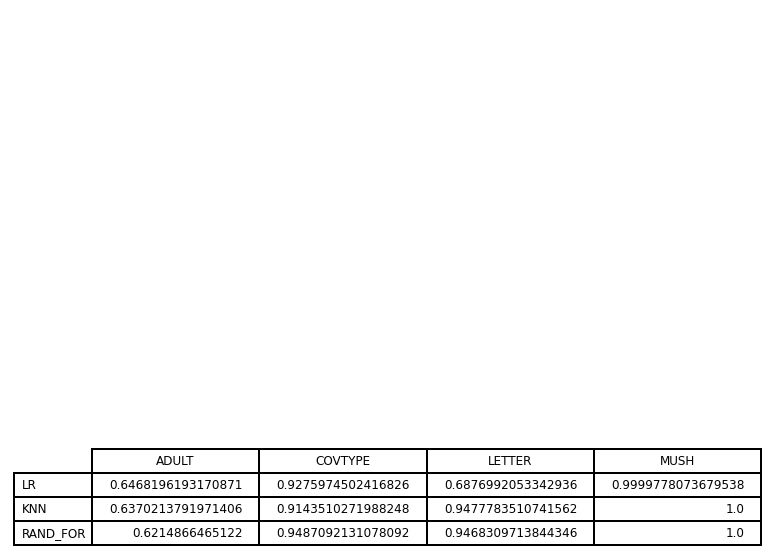

In [162]:
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, results_test_data)  # where df is your data frame

plt.savefig('results_test_data.png')

In [105]:
# Get metrics each algo/data combo averaged across 5 trials (algorithms in rows, sets in columns) - train performance
results_train_data = np.zeros((3, 4))
for col, data in enumerate(datasets):
    for row, algo in enumerate(algorithms):
        sums = [sum_ for sum_ in results_train[col][data][algo].sum()]
        avg = sum(sums)/15
        results_train_data[row][col] = avg

In [106]:
results_train_data = pd.DataFrame(results_train_data, columns = datasets, index = algorithms)
results_train_data

,ADULT,COVTYPE,LETTER,MUSH
LR,0.648534,0.932447,0.686323,0.999959
KNN,0.785876,1.000000,1.000000,1.000000
RAND_FOR,0.999960,1.000000,1.000000,1.000000


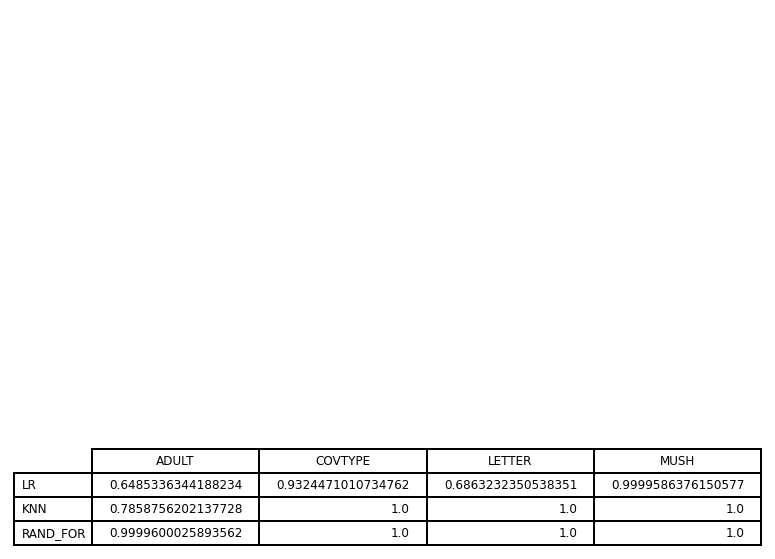

In [163]:
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, results_train_data)  # where df is your data frame

plt.savefig('results_train_data.png')

In [107]:
# Get accuracy, FSC, and AUC averaged across all data sets (algorithms in rows, metrics in columns) - test performance
acc = 0
f1 = 0
roc = 0
results_test_metrics = np.zeros((3, 3))

for row, algo in enumerate(algorithms):
    for i, data in enumerate(datasets):
        sums = [sum_ for sum_ in results_test[i][data][algo].sum()]
        acc += sums[0]
        f1 += sums[1]
        roc += sums[2]
    results_test_metrics[row][0] = acc/20
    results_test_metrics[row][1] = f1/20
    results_test_metrics[row][2] = roc/20
    acc = 0
    f1 = 0
    roc = 0

In [108]:
results_test_metrics = pd.DataFrame(results_test_metrics, columns = metrics, index = algorithms)

In [109]:
sum_metrics = [sum_/3 for sum_ in results_test_metrics.sum(axis=1)]
results_test_metrics['avg'] = sum_metrics
results_test_metrics

,accuracy,f1,roc_auc,avg
LR,0.832087,0.797072,0.817412,0.815524
KNN,0.893987,0.859257,0.871119,0.874788
RAND_FOR,0.891443,0.863861,0.882466,0.879257


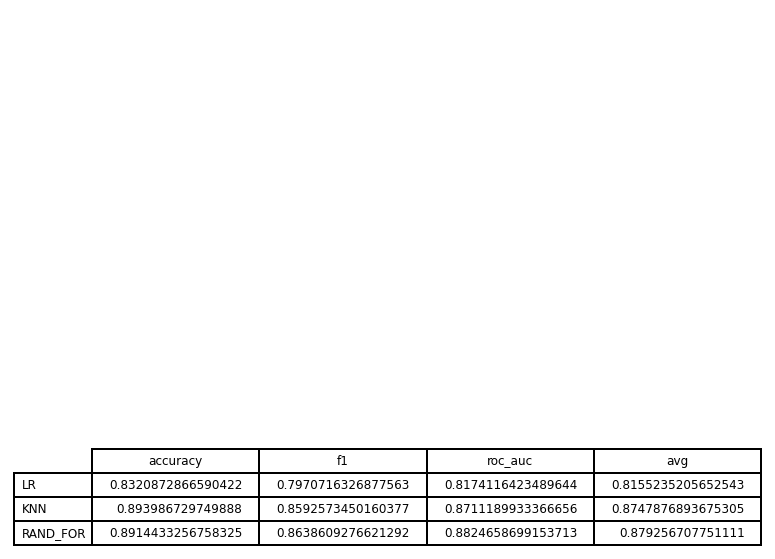

In [164]:
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, results_test_metrics)  # where df is your data frame

plt.savefig('results_test_metrics.png')

In [110]:
# Get accuracy, FSC, and AUC averaged across all data sets (algorithms in rows, metrics in columns) - test performance
acc = 0
f1 = 0
roc = 0
results_train_metrics = np.zeros((3, 3))

for row, algo in enumerate(algorithms):
    for i, data in enumerate(datasets):
        sums = [sum_ for sum_ in results_train[i][data][algo].sum()]
        acc += sums[0]
        f1 += sums[1]
        roc += sums[2]
    results_train_metrics[row][0] = acc/20
    results_train_metrics[row][1] = f1/20
    results_train_metrics[row][2] = roc/20
    acc = 0
    f1 = 0
    roc = 0

In [111]:
results_train_metrics = pd.DataFrame(results_train_metrics, columns = metrics, index = algorithms)

sum_metrics = [sum_/3 for sum_ in results_train_metrics.sum(axis=1)]
results_train_metrics['avg'] = sum_metrics
results_train_metrics

,accuracy,f1,roc_auc,avg
LR,0.83261,0.798836,0.819001,0.816816
KNN,0.93087,0.925888,0.982649,0.946469
RAND_FOR,0.99999,0.999990,0.999990,0.999990


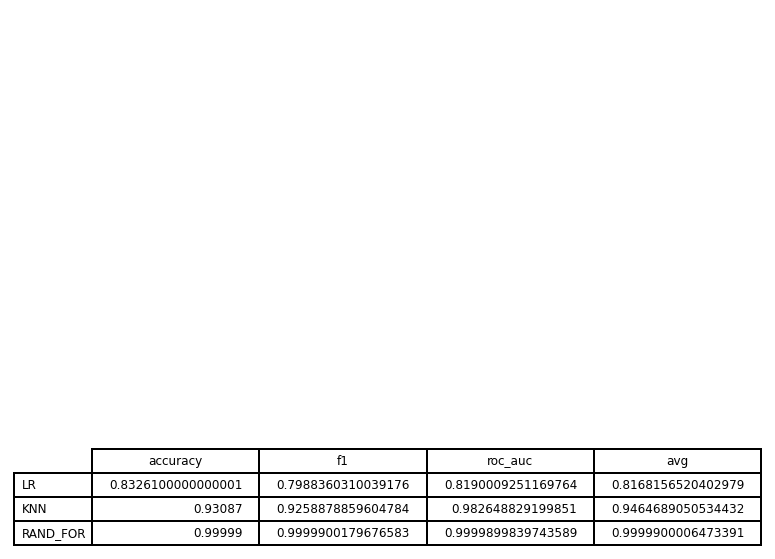

In [165]:
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, results_train_metrics)  # where df is your data frame

plt.savefig('results_train_metrics.png')

In [2]:
#results_test_data.to_csv('results_over_datasets_test',index=True)
#results_train_data.to_csv('results_over_datasets_train',index=True)
#results_test_metrics.to_csv('results_over_metrics_test',index=True)
#results_train_metrics.to_csv('results_over_metrics_train',index=True)

In [141]:
test_scores = [LRD1_test, KNND1_test, RDF1_test, LRD2_test, KNND2_test, 
              RDF2_test, LRD3_test, KNND3_test, RDF3_test, LRD4_test, 
              KNND4_test, RDF4_test]

In [142]:
test_scores = pd.concat(test_scores, keys=['LRD1_test', 'KNND1_test', 'RDF1_test', 'LRD2_test', 'KNND2_test', 
              'RDF2_test', 'LRD3_test', 'KNND3_test', 'RDF3_test', 'LRD4_test', 
              'KNND4_test', 'RDF4_test'])

In [143]:
test_scores

accuracy        f1   roc_auc
LRD1_test  0  0.648004  0.637431  0.650773
           1  0.648352  0.641888  0.648317
           2  0.648526  0.643226  0.648503
           3  0.650266  0.642361  0.650219
           4  0.642559  0.655206  0.646665
KNND1_test 0  0.640669  0.618143  0.641844
           1  0.644846  0.622340  0.644724
           2  0.643504  0.623637  0.643562
           3  0.643976  0.613684  0.643784
           4  0.648700  0.633883  0.648024
RDF1_test  0  0.630178  0.597705  0.629814
           1  0.634777  0.607723  0.634830
           2  0.622271  0.595176  0.623053
           3  0.632415  0.604092  0.635773
           4  0.632639  0.609638  0.632216
LRD2_test  0  0.982240  0.874647  0.922030
           1  0.982920  0.880559  0.929163
           2  0.982560  0.878484  0.936642
           3  0.982680  0.874248  0.917408
           4  0.981640  0.869713  0.919026
KNND2_test 0  0.981160  0.871697  0.892429
           1  0.980040  0.863996  0.887508
           2  0.977920  0.859572  0.890140
           3  0.980200  0.864048  0.904100
           4  0.982120  0.877702  0.902633
RDF2_test  0  0.985080  0.902247  0.952024
           1  0.986400  0.912027  0.954420
           2  0.986520  0.908486  0.954990
           3  0.987800  0.914793  0.939975
           4  0.985520  0.906932  0.953425
LRD3_test  0  0.696533  0.670001  0.694572
           1  0.696400  0.662654  0.693525
           2  0.697467  0.663294  0.694383
           3  0.700600  0.673120  0.698310
           4  0.701000  0.674599  0.699030
KNND3_test 0  0.953267  0.949499  0.943833
           1  0.950267  0.946161  0.943907
           2  0.952600  0.948690  0.946607
           3  0.949467  0.945144  0.945068
           4  0.951000  0.946951  0.944216
RDF3_test  0  0.949733  0.944742  0.949293
           1  0.946333  0.941220  0.944273
           2  0.949533  0.943231  0.947050
           3  0.949000  0.943726  0.948284
           4  0.950667  0.945481  0.949898
LRD4_test  0  1.000000  1.000000  1.000000
           1  1.000000  1.000000  1.000000
           2  1.000000  1.000000  1.000000
           3  1.000000  1.000000  0.999667
           4  1.000000  1.000000  1.000000
KNND4_test 0  1.000000  1.000000  1.000000
           1  1.000000  1.000000  1.000000
           2  1.000000  1.000000  1.000000
           3  1.000000  1.000000  1.000000
           4  1.000000  1.000000  1.000000
RDF4_test  0  1.000000  1.000000  1.000000
           1  1.000000  1.000000  1.000000
           2  1.000000  1.000000  1.000000
           3  1.000000  1.000000  1.000000
           4  1.000000  1.000000  1.000000

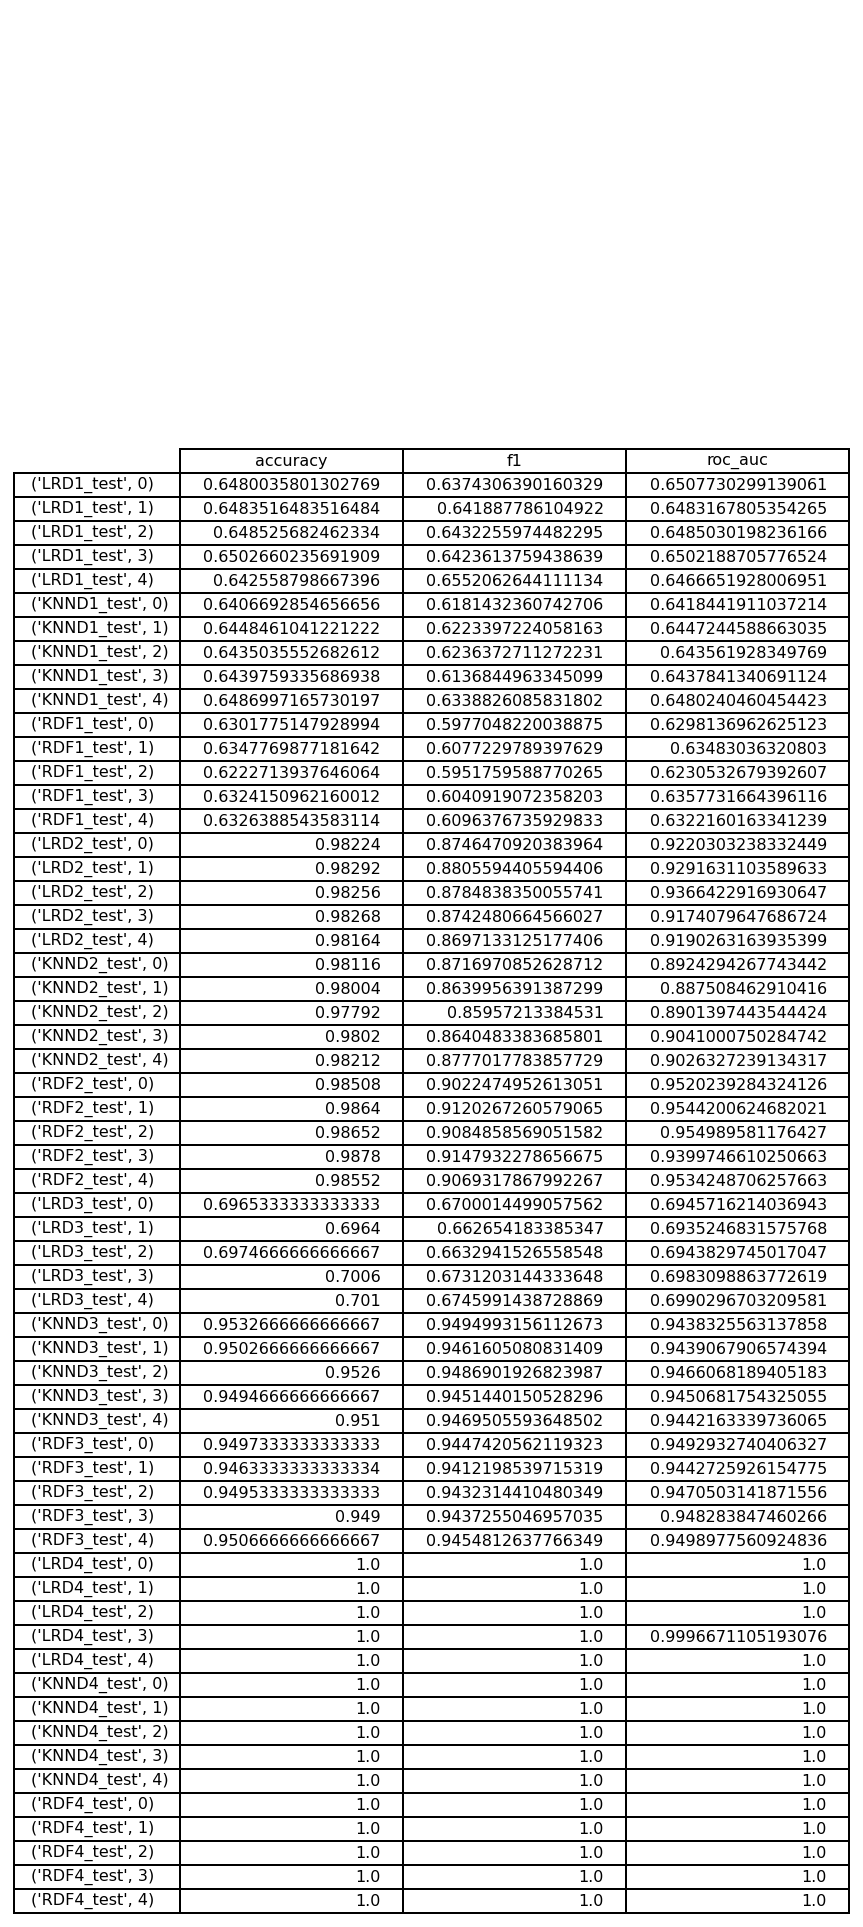

In [153]:
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, test_scores)  # where df is your data frame

plt.savefig('test_scores.png')

In [166]:
test_scores.to_csv('raw_test_scores',index=True)

In [167]:
train_scores = [LRD1_train, KNND1_train, RDF1_train, LRD2_train, KNND2_train, 
              RDF2_train, LRD3_train, KNND3_train, RDF3_train, LRD4_train, 
              KNND4_train, RDF4_train]

In [169]:
train_scores = pd.concat(train_scores, keys=['LRD1_train', 'KNND1_train', 'RDF1_train', 'LRD2_train', 'KNND2_train', 
              'RDF2_train', 'LRD3_train', 'KNND3_train', 'RDF3_train', 'LRD4_train', 
              'KNND4_train', 'RDF4_train'])

In [170]:
train_scores

accuracy        f1   roc_auc
LRD1_train  0    0.6490  0.639835  0.652101
            1    0.6556  0.651558  0.655595
            2    0.6384  0.634058  0.638432
            3    0.6532  0.648418  0.653217
            4    0.6500  0.657489  0.651100
KNND1_train 0    0.6674  1.000000  1.000000
            1    0.6532  0.631221  0.653176
            2    0.6534  0.621645  0.999800
            3    1.0000  0.630736  1.000000
            4    0.6434  0.634156  1.000000
RDF1_train  0    1.0000  1.000000  1.000000
            1    1.0000  1.000000  1.000000
            2    0.9998  0.999800  0.999800
            3    1.0000  1.000000  1.000000
            4    1.0000  1.000000  1.000000
LRD2_train  0    0.9840  0.880952  0.930261
            1    0.9802  0.853333  0.915101
            2    0.9870  0.913218  0.946332
            3    0.9840  0.892351  0.934885
            4    0.9824  0.873926  0.928746
KNND2_train 0    1.0000  1.000000  1.000000
            1    1.0000  1.000000  1.000000
            2    1.0000  1.000000  1.000000
            3    1.0000  1.000000  1.000000
            4    1.0000  1.000000  1.000000
RDF2_train  0    1.0000  1.000000  1.000000
            1    1.0000  1.000000  1.000000
            2    1.0000  1.000000  1.000000
            3    1.0000  1.000000  1.000000
            4    1.0000  1.000000  1.000000
LRD3_train  0    0.7040  0.680484  0.702505
            1    0.6914  0.652569  0.688951
            2    0.6940  0.652589  0.688929
            3    0.6978  0.670159  0.695223
            4    0.7012  0.675781  0.699259
KNND3_train 0    1.0000  1.000000  1.000000
            1    1.0000  1.000000  1.000000
            2    1.0000  1.000000  1.000000
            3    1.0000  1.000000  1.000000
            4    1.0000  1.000000  1.000000
RDF3_train  0    1.0000  1.000000  1.000000
            1    1.0000  1.000000  1.000000
            2    1.0000  1.000000  1.000000
            3    1.0000  1.000000  1.000000
            4    1.0000  1.000000  1.000000
LRD4_train  0    1.0000  1.000000  1.000000
            1    1.0000  1.000000  1.000000
            2    1.0000  1.000000  1.000000
            3    1.0000  1.000000  0.999586
            4    1.0000  1.000000  0.999794
KNND4_train 0    1.0000  1.000000  1.000000
            1    1.0000  1.000000  1.000000
            2    1.0000  1.000000  1.000000
            3    1.0000  1.000000  1.000000
            4    1.0000  1.000000  1.000000
RDF4_train  0    1.0000  1.000000  1.000000
            1    1.0000  1.000000  1.000000
            2    1.0000  1.000000  1.000000
            3    1.0000  1.000000  1.000000
            4    1.0000  1.000000  1.000000

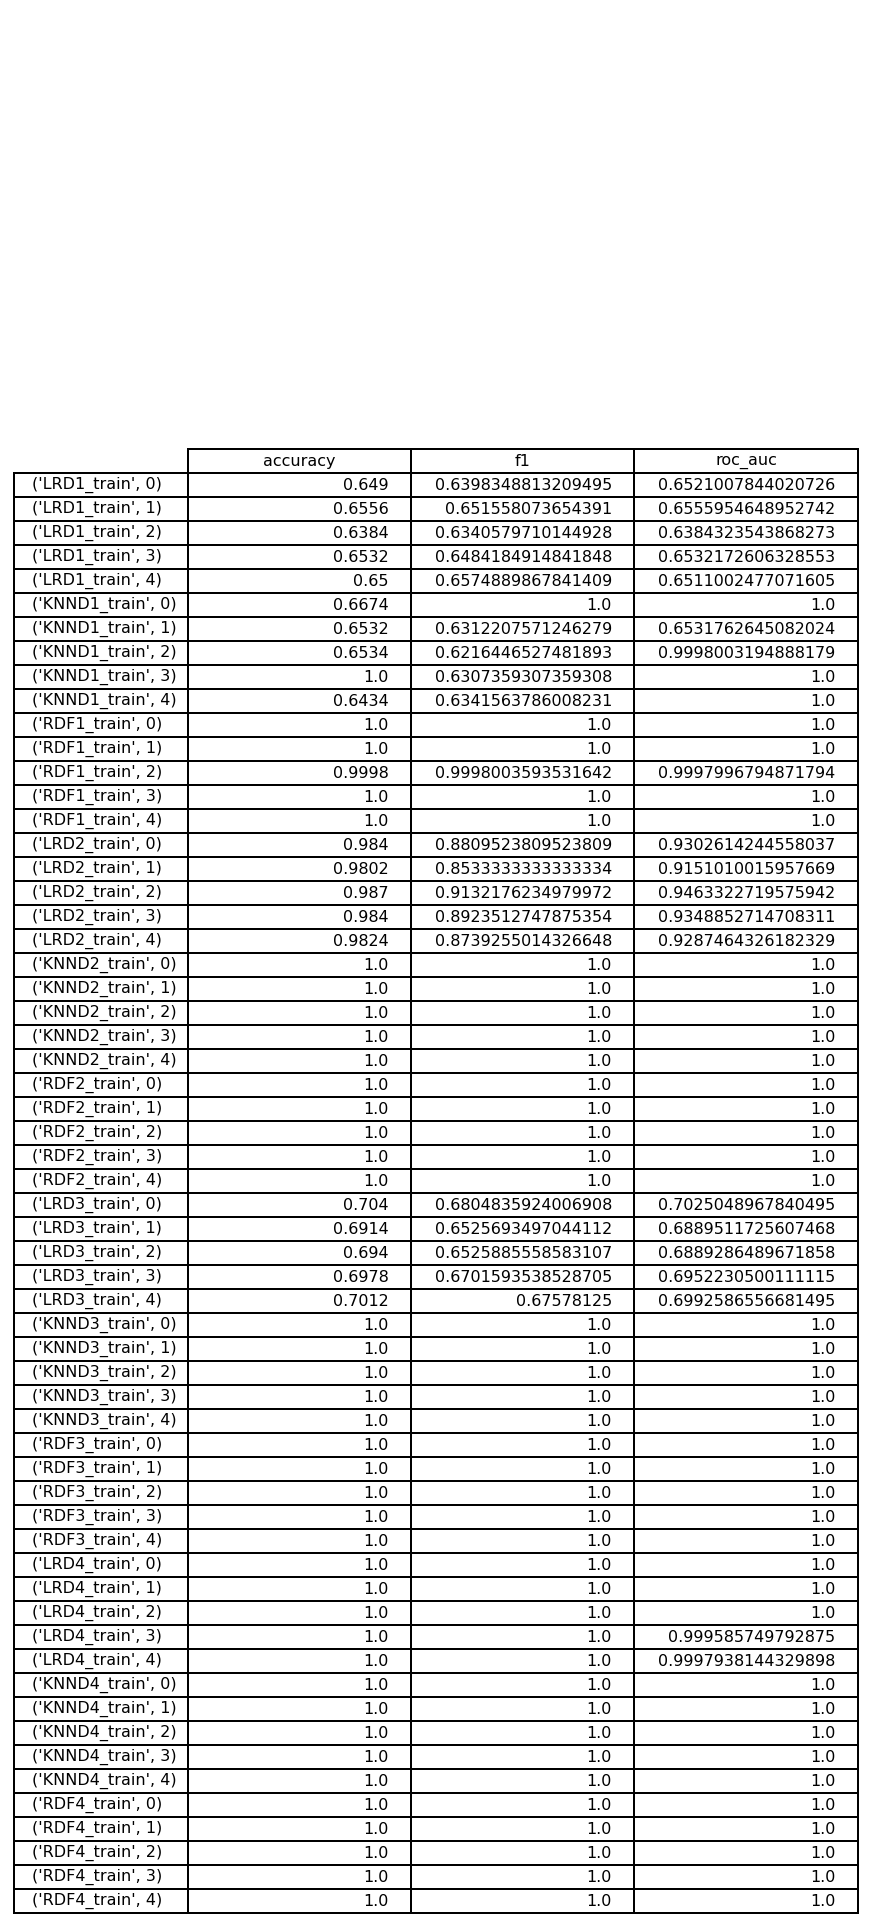

In [171]:
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, train_scores)  # where df is your data frame

plt.savefig('train_scores.png')

In [3]:
results_test_data = pd.read_csv('results_over_datasets_test', index_col = 0)  
results_test_metrics = pd.read_csv('results_over_metrics_test', index_col = 0) 
results_train_data = pd.read_csv('results_over_datasets_train', index_col = 0) 
results_train_metrics = pd.read_csv('results_over_metrics_train', index_col = 0) 

In [5]:
results_test_data

,ADULT,COVTYPE,LETTER,MUSH
LR,0.646820,0.927597,0.687699,0.999978
KNN,0.637021,0.914351,0.947778,1.000000
RAND_FOR,0.621487,0.948709,0.946831,1.000000


In [6]:
def bold_max(s):
    '''
    Bold the maximum in each dataset column.
    '''
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

In [7]:
results_test_data = results_test_data.style.apply(bold_max)

In [8]:
results_test_data

,ADULT,COVTYPE,LETTER,MUSH
LR,0.646820,0.927597,0.687699,0.999978
KNN,0.637021,0.914351,0.947778,1.000000
RAND_FOR,0.621487,0.948709,0.946831,1.000000


In [4]:
results_test = pd.read_csv('raw_test_scores', index_col = 0)  

In [13]:
results_test.head()

,Unnamed: 1,accuracy,f1,roc_auc
LRD1_test,0,0.648004,0.637431,0.650773
LRD1_test,1,0.648352,0.641888,0.648317
LRD1_test,2,0.648526,0.643226,0.648503
LRD1_test,3,0.650266,0.642361,0.650219
LRD1_test,4,0.642559,0.655206,0.646665


In [14]:
results_test['Unnamed: 1']

LRD1_test     0
LRD1_test     1
LRD1_test     2
LRD1_test     3
LRD1_test     4
KNND1_test    0
KNND1_test    1
KNND1_test    2
KNND1_test    3
KNND1_test    4
RDF1_test     0
RDF1_test     1
RDF1_test     2
RDF1_test     3
RDF1_test     4
LRD2_test     0
LRD2_test     1
LRD2_test     2
LRD2_test     3
LRD2_test     4
KNND2_test    0
KNND2_test    1
KNND2_test    2
KNND2_test    3
KNND2_test    4
RDF2_test     0
RDF2_test     1
RDF2_test     2
RDF2_test     3
RDF2_test     4
LRD3_test     0
LRD3_test     1
LRD3_test     2
LRD3_test     3
LRD3_test     4
KNND3_test    0
KNND3_test    1
KNND3_test    2
KNND3_test    3
KNND3_test    4
RDF3_test     0
RDF3_test     1
RDF3_test     2
RDF3_test     3
RDF3_test     4
LRD4_test     0
LRD4_test     1
LRD4_test     2
LRD4_test     3
LRD4_test     4
KNND4_test    0
KNND4_test    1
KNND4_test    2
KNND4_test    3
KNND4_test    4
RDF4_test     0
RDF4_test     1
RDF4_test     2
RDF4_test     3
RDF4_test     4
Name: Unnamed: 1, dtype: int64

In [15]:
results_test = results_test.rename(columns={"Unnamed: 1": "Algo/Data"})

In [25]:
print(results_test.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  Algo/Data &  accuracy &        f1 &   roc\_auc \\
\midrule
LRD1\_test  &          0 &  0.648004 &  0.637431 &  0.650773 \\
LRD1\_test  &          1 &  0.648352 &  0.641888 &  0.648317 \\
LRD1\_test  &          2 &  0.648526 &  0.643226 &  0.648503 \\
LRD1\_test  &          3 &  0.650266 &  0.642361 &  0.650219 \\
LRD1\_test  &          4 &  0.642559 &  0.655206 &  0.646665 \\
KNND1\_test &          0 &  0.640669 &  0.618143 &  0.641844 \\
KNND1\_test &          1 &  0.644846 &  0.622340 &  0.644724 \\
KNND1\_test &          2 &  0.643504 &  0.623637 &  0.643562 \\
KNND1\_test &          3 &  0.643976 &  0.613684 &  0.643784 \\
KNND1\_test &          4 &  0.648700 &  0.633883 &  0.648024 \\
RDF1\_test  &          0 &  0.630178 &  0.597705 &  0.629814 \\
RDF1\_test  &          1 &  0.634777 &  0.607723 &  0.634830 \\
RDF1\_test  &          2 &  0.622271 &  0.595176 &  0.623053 \\
RDF1\_test  &          3 &  0.632415 &  0.604092 &  0.635773 \\
RDF1\_t

In [16]:
results_test

,Algo/Data,accuracy,f1,roc_auc
LRD1_test,0,0.648004,0.637431,0.650773
LRD1_test,1,0.648352,0.641888,0.648317
LRD1_test,2,0.648526,0.643226,0.648503
LRD1_test,3,0.650266,0.642361,0.650219
LRD1_test,4,0.642559,0.655206,0.646665
KNND1_test,0,0.640669,0.618143,0.641844
KNND1_test,1,0.644846,0.622340,0.644724
KNND1_test,2,0.643504,0.623637,0.643562
KNND1_test,3,0.643976,0.613684,0.643784
KNND1_test,4,0.648700,0.633883,0.648024


In [17]:
results_test.iloc[5, :]

Algo/Data    0.000000
accuracy     0.640669
f1           0.618143
roc_auc      0.641844
Name: KNND1_test, dtype: float64

In [18]:
print(results_test_data.data.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &     ADULT &   COVTYPE &    LETTER &      MUSH \\
\midrule
LR       &  0.646820 &  0.927597 &  0.687699 &  0.999978 \\
KNN      &  0.637021 &  0.914351 &  0.947778 &  1.000000 \\
RAND\_FOR &  0.621487 &  0.948709 &  0.946831 &  1.000000 \\
\bottomrule
\end{tabular}



In [19]:
# P-values for algorithms across metrics for each algo/dataset combo

# Indices for LR - D1:4: [0,4], [15, 19], [30,34], [45, 49]
# Indices for KNN - D1:4: [5, 9], [20,24], [35, 39], [50, 54]
# Indices for RF - D1:4: [10,14], [25, 29], [40, 44], [55, 59]

p_values_data = np.zeros((3, 4))

# Best for D1: ADULT - LR
LRD1 = results_test.iloc[:5, 1:].to_numpy().reshape((15,1))
KNND1 = results_test.iloc[5:10, 1:].to_numpy().reshape((15,1))
RFD1 = results_test.iloc[10:15, 1:].to_numpy().reshape((15,1))

p_values_data[0][0] = stats.ttest_rel(LRD1,LRD1)[1][0]
p_values_data[1][0] = stats.ttest_rel(LRD1,KNND1)[1][0]
p_values_data[2][0] = stats.ttest_rel(LRD1,RFD1)[1][0]

# Best for D2: COVTYPE - RF
LRD2 = results_test.iloc[15:20, 1:].to_numpy().reshape((15,1))
KNND2 = results_test.iloc[20:25, 1:].to_numpy().reshape((15,1))
RFD2 = results_test.iloc[25:30, 1:].to_numpy().reshape((15,1))

p_values_data[0][1] = stats.ttest_rel(RFD2,LRD2)[1][0]
p_values_data[1][1] = stats.ttest_rel(RFD2,KNND2)[1][0]
p_values_data[2][1] = stats.ttest_rel(RFD2,RFD2)[1][0]

# Best for D3: COVTYPE - KNN
LRD3 = results_test.iloc[30:35, 1:].to_numpy().reshape((15,1))
KNND3 = results_test.iloc[35:40, 1:].to_numpy().reshape((15,1))
RFD3 = results_test.iloc[40:45, 1:].to_numpy().reshape((15,1))

p_values_data[0][2] = stats.ttest_rel(KNND3,LRD3)[1][0]
p_values_data[1][2] = stats.ttest_rel(KNND3,KNND3)[1][0]
p_values_data[2][2] = stats.ttest_rel(KNND3,RFD3)[1][0]

# Best for D4: MUSH - KNN or RF - use RF
LRD4 = results_test.iloc[45:50, 1:].to_numpy().reshape((15,1))
KNND4 = results_test.iloc[50:55, 1:].to_numpy().reshape((15,1))
RFD4 = results_test.iloc[55:60, 1:].to_numpy().reshape((15,1))

p_values_data[0][3] = stats.ttest_rel(RFD4,LRD4)[1][0]
p_values_data[1][3] = stats.ttest_rel(RFD4,KNND4)[1][0]
p_values_data[2][3] = stats.ttest_rel(RFD4,RFD4)[1][0]

# If the p-value is nan then no variance because performed t-test with same algo or same results across trials
pd.DataFrame(p_values_data, columns = datasets, index = algorithms)

,ADULT,COVTYPE,LETTER,MUSH
LR,NaN,0.000035,2.726139e-19,0.334282
KNN,0.001502,0.000056,NaN,NaN
RAND_FOR,0.000002,NaN,3.209287e-01,NaN


In [20]:
print(pd.DataFrame(p_values_data, columns = datasets, index = algorithms).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &     ADULT &   COVTYPE &        LETTER &      MUSH \\
\midrule
LR       &       NaN &  0.000035 &  2.726139e-19 &  0.334282 \\
KNN      &  0.001502 &  0.000056 &           NaN &       NaN \\
RAND\_FOR &  0.000002 &       NaN &  3.209287e-01 &       NaN \\
\bottomrule
\end{tabular}



In [21]:
results_test_metrics = results_test_metrics.style.apply(bold_max)
results_test_metrics

,accuracy,f1,roc_auc,avg
LR,0.832087,0.797072,0.817412,0.815524
KNN,0.893987,0.859257,0.871119,0.874788
RAND_FOR,0.891443,0.863861,0.882466,0.879257


In [22]:
print(results_test_metrics.data.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  accuracy &        f1 &   roc\_auc &       avg \\
\midrule
LR       &  0.832087 &  0.797072 &  0.817412 &  0.815524 \\
KNN      &  0.893987 &  0.859257 &  0.871119 &  0.874788 \\
RAND\_FOR &  0.891443 &  0.863861 &  0.882466 &  0.879257 \\
\bottomrule
\end{tabular}



In [23]:
# P-values for algorithms across datasets for each algo/metric combo

# Indices for LR - D1:4: [0,4], [15, 19], [30,34], [45, 49]
# Indices for KNN - D1:4: [5, 9], [20,24], [35, 39], [50, 54]
# Indices for RF - D1:4: [10,14], [25, 29], [40, 44], [55, 59]

p_values_metrics = np.zeros((3, 3))

# Best for metric 1: accuracy - KNN
LR_acc1 = results_test.iloc[:5, 1]
LR_acc2 = results_test.iloc[15:20, 1]
LR_acc3 = results_test.iloc[30:35, 1]
LR_acc4 = results_test.iloc[45:50, 1]
LR1 = pd.concat([LR_acc1, LR_acc2, LR_acc3, LR_acc4])

KNN_acc1 = results_test.iloc[5:10, 1]
KNN_acc2 = results_test.iloc[20:25, 1]
KNN_acc3 = results_test.iloc[35:40, 1]
KNN_acc4 = results_test.iloc[50:55, 1]
KNN1 = pd.concat([KNN_acc1, KNN_acc2, KNN_acc3, KNN_acc4])

RF_acc1 = results_test.iloc[10:15, 1]
RF_acc2 = results_test.iloc[25:30, 1]
RF_acc3 = results_test.iloc[40:45, 1]
RF_acc4 = results_test.iloc[55:60, 1]
RF1 = pd.concat([RF_acc1, RF_acc2, RF_acc3, RF_acc4])

p_values_metrics[0][0] = stats.ttest_rel(KNN1,LR1)[1]
p_values_metrics[1][0] = stats.ttest_rel(KNN1,KNN1)[1]
p_values_data[2][0] = stats.ttest_rel(KNN1,RF1)[1]

# Best for metric 2: f1 - random forest
LR_f1_1 = results_test.iloc[:5, 2]
LR_f1_2 = results_test.iloc[15:20, 2]
LR_f1_3 = results_test.iloc[30:35, 2]
LR_f1_4 = results_test.iloc[45:50, 2]
LR2 = pd.concat([LR_f1_1, LR_f1_2, LR_f1_3, LR_f1_4])

KNN_f1_1 = results_test.iloc[5:10, 2]
KNN_f1_2 = results_test.iloc[20:25, 2]
KNN_f1_3 = results_test.iloc[35:40, 2]
KNN_f1_4 = results_test.iloc[50:55, 2]
KNN2 = pd.concat([KNN_f1_1, KNN_f1_2, KNN_f1_3, KNN_f1_4])

RF_f1_1 = results_test.iloc[10:15, 2]
RF_f1_2 = results_test.iloc[25:30, 2]
RF_f1_3 = results_test.iloc[40:45, 2]
RF_f1_4 = results_test.iloc[55:60, 2]
RF2 = pd.concat([RF_f1_1, RF_f1_2, RF_f1_3, RF_f1_4])

p_values_metrics[0][1] = stats.ttest_rel(RF2,LR2)[1]
p_values_metrics[1][1] = stats.ttest_rel(RF2,KNN2)[1]
p_values_metrics[2][1] = stats.ttest_rel(RF2,RF2)[1]

# Best for metric 3: roc - random forest
LR_roc_1 = results_test.iloc[:5, 3]
LR_roc_2 = results_test.iloc[15:20, 3]
LR_roc_3 = results_test.iloc[30:35, 3]
LR_roc_4 = results_test.iloc[45:50, 3]
LR3 = pd.concat([LR_roc_1, LR_roc_2, LR_roc_3, LR_roc_4])

KNN_roc_1 = results_test.iloc[5:10, 3]
KNN_roc_2 = results_test.iloc[20:25, 3]
KNN_roc_3 = results_test.iloc[35:40, 3]
KNN_roc_4 = results_test.iloc[50:55, 3]
KNN3 = pd.concat([KNN_roc_1, KNN_roc_2, KNN_roc_3, KNN_roc_4])

RF_roc_1 = results_test.iloc[10:15, 3]
RF_roc_2 = results_test.iloc[25:30, 3]
RF_roc_3 = results_test.iloc[40:45, 3]
RF_roc_4 = results_test.iloc[55:60, 3]
RF3 = pd.concat([RF_roc_1, RF_roc_2, RF_roc_3, RF_roc_4])

p_values_metrics[0][2] = stats.ttest_rel(RF3,LR3)[1]
p_values_metrics[1][2] = stats.ttest_rel(RF3,KNN3)[1]
p_values_metrics[2][2] = stats.ttest_rel(RF3,RF3)[1]

# If the p-value is nan then no variance because performed t-test with same algo or same results across trials
pd.DataFrame(p_values_metrics, columns = metrics, index = algorithms)

,accuracy,f1,roc_auc
LR,0.024379,0.028835,0.017531
KNN,NaN,0.399488,0.082660
RAND_FOR,0.000000,NaN,NaN


In [24]:
print(pd.DataFrame(p_values_metrics, columns = metrics, index = algorithms).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  accuracy &        f1 &   roc\_auc \\
\midrule
LR       &  0.024379 &  0.028835 &  0.017531 \\
KNN      &       NaN &  0.399488 &  0.082660 \\
RAND\_FOR &  0.000000 &       NaN &       NaN \\
\bottomrule
\end{tabular}



In [27]:
results_train_data

,ADULT,COVTYPE,LETTER,MUSH
LR,0.648534,0.932447,0.686323,0.999959
KNN,0.785876,1.000000,1.000000,1.000000
RAND_FOR,0.999960,1.000000,1.000000,1.000000


In [28]:
results_train_metrics

,accuracy,f1,roc_auc,avg
LR,0.83261,0.798836,0.819001,0.816816
KNN,0.93087,0.925888,0.982649,0.946469
RAND_FOR,0.99999,0.999990,0.999990,0.999990
